In [91]:
import csv
import sys
import copy

csv.field_size_limit(sys.maxsize)

import uuid
import json
import random
import itertools

import pprint
pp = pprint.PrettyPrinter(indent=2)

import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from matplotlib.colors import LinearSegmentedColormap
plt.rcParams['figure.figsize'] = (12.0, 10.0)

## Within-Cluster Object Layout

In [92]:
def place_objects_in_cluster(num_objects, cluster_centroid, depth=0, cluster_width=20, object_size=3, object_padding=6, **kwargs):
    
    accepted_locations = []
    overlapped_locations = []
    
    acceptable_range = range(round(object_size/2), cluster_width - round(object_size/2))
        
    while len(accepted_locations) < num_objects:
    
        new_x_loc = random.choice(acceptable_range)
        new_y_loc = random.choice(acceptable_range)
        
        overlapping = [(abs(obj["x"] - new_x_loc) < object_padding) and (abs(obj["y"] - new_y_loc) < object_padding) for obj in accepted_locations]

        if any(overlapping):
            overlapped_locations.append({"x": new_x_loc, "y": new_y_loc})
            
        else: 
            accepted_locations.append({"x": new_x_loc, "y": new_y_loc})
            
        if len(overlapped_locations) > 500:
            if depth > 10:
                print("Placement infeasible for cluster: {} objects, {} size, {} padding, {} width.".format(
                num_objects, object_size, object_padding, cluster_width))
                raise YouDoneFuckedUpError
            
            else:
                depth += 1
                return place_objects_in_cluster(num_objects, cluster_centroid, 
                                                depth=depth, cluster_width=cluster_width, 
                                                object_size=object_size, object_padding=object_padding, 
                                                **kwargs)
    
    x_offset = cluster_centroid[0] - int(cluster_width / 2)
    y_offset = cluster_centroid[1] - int(cluster_width / 2)
    
    for a in accepted_locations:
        a["x"] = a["x"] + x_offset
        a["y"] = a["y"] + y_offset
        
    return accepted_locations, acceptable_range

def plot_objects(locations, acceptable_range, object_size=3):
    
    candidates = list(itertools.product(acceptable_range, repeat=2))
    plt.scatter([a[0] for a in candidates], [a[1] for a in candidates], color="g", s=10, alpha=.4, label="candidates")
    
    objects_df = pd.DataFrame(locations)
    
    offset = range(-int(object_size/2), int(object_size/2) + 1)
    
    for i in list(itertools.product(offset, repeat=2)):
        plt.scatter(objects_df.x + i[0], objects_df.y + i[1], color='k', label="selected")

    plt.xlim(min(acceptable_range), max(acceptable_range))
    plt.ylim(max(acceptable_range), min(acceptable_range))
#     plt.legend(loc="best")
    plt.show()

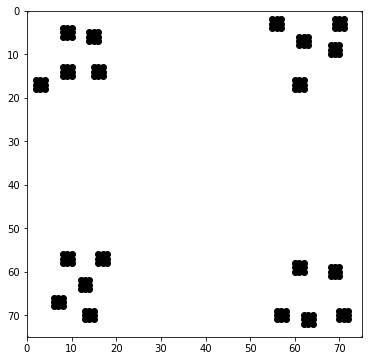

In [93]:
# Acceptable cluster centroids are (x,y)~(12, 37, 62)
# Which correspond to left / middle / right thirds of the board respectively

CENTROID_LOW = 11
CENTROID_HIGH = 64

TOP_LEFT = (CENTROID_LOW, CENTROID_LOW)
TOP_RIGHT = (CENTROID_HIGH, CENTROID_LOW)
BOTTOM_RIGHT = (CENTROID_HIGH, CENTROID_HIGH)
BOTTOM_LEFT = (CENTROID_LOW, CENTROID_HIGH)

clockwise_cluster_list = [TOP_LEFT, TOP_RIGHT, BOTTOM_RIGHT, BOTTOM_LEFT]

objects = []

for cluster in clockwise_cluster_list:
    cluster_objects, _ =  place_objects_in_cluster(5, cluster, cluster_width=20, object_padding=6)
    objects.extend(cluster_objects)

plt.figure(figsize=(6,6))
plot_objects(objects, [0,75])


## Generating object values

In [94]:
def assign_object_values(num_positive, num_objects=5, num_color_values=4):
    
    if num_positive > num_objects:
        raise ValueError("Can't have more positive objects than total objects.")
    objects = [{"value": 1} for i in range(0, num_positive)] + [{"value": -1} for i in range(0, num_objects-num_positive)]
    for o in objects:
        o.update({"mask_value": random.choice(range(0, num_color_values))})
    return objects
    
assign_object_values(3)

[{'value': 1, 'mask_value': 2},
 {'value': 1, 'mask_value': 2},
 {'value': 1, 'mask_value': 2},
 {'value': -1, 'mask_value': 2},
 {'value': -1, 'mask_value': 1}]

## Level Configuration: cluster centroids and values

In [95]:
example_level_configurations = [
    
    # Each level is a list of clusters
    
    # Level 1: 2 clusters
    [{
        "centroid": TOP_LEFT,
        "pos_objects": 3,
        "num_objects": 5,
    }, {
        "centroid": TOP_RIGHT,
        "pos_objects": 2,
        "num_objects": 5,
    }],
    
    # Level 2: 3 clusters
    [{
        "centroid": TOP_LEFT,
        "pos_objects": 3,
        "num_objects": 5,
    }, {
        "centroid": TOP_RIGHT,
        "pos_objects": 1,
        "num_objects": 5,
    }, {
        "centroid": BOTTOM_RIGHT,
        "pos_objects": 0,
        "num_objects": 5,
    }]
]

In [96]:
def generate_level_clusters(cluster_config_list, global_gameplay_config):
    
    configs = copy.deepcopy(cluster_config_list)
    generated_clusters = []
    
    for i, config in enumerate(configs):
        
        object_locations, _ = place_objects_in_cluster(config["num_objects"], 
                                                       config["centroid"],
                                                       object_padding=global_gameplay_config.get("object_padding", 6))
        
        object_values = assign_object_values(config["pos_objects"], 
                                             config["num_objects"])
        
        for loc, value in zip(object_locations, object_values):
            loc.update(value)
            loc["cluster_id"] = i+1
            
        config.update({"id": i+1,
                       "actual_positive_value": sum([v["value"] for v in object_values if v.get("value") > 0]),
                       "actual_negative_value": sum([v["value"] for v in object_values if v.get("value") < 0])})
        
        generated_clusters.append({"config": config, "objects": object_locations})
        
    return generated_clusters

[ { 'actual_negative_value': -2,
    'actual_positive_value': 3,
    'centroid': (11, 11),
    'id': 1,
    'num_objects': 5,
    'pos_objects': 3},
  { 'actual_negative_value': -3,
    'actual_positive_value': 2,
    'centroid': (64, 11),
    'id': 2,
    'num_objects': 5,
    'pos_objects': 2}]
[ {'cluster_id': 1, 'mask_value': 2, 'value': 1, 'x': 9, 'y': 15},
  {'cluster_id': 1, 'mask_value': 3, 'value': 1, 'x': 6, 'y': 8},
  {'cluster_id': 1, 'mask_value': 0, 'value': 1, 'x': 15, 'y': 10},
  {'cluster_id': 1, 'mask_value': 0, 'value': -1, 'x': 17, 'y': 18},
  {'cluster_id': 1, 'mask_value': 3, 'value': -1, 'x': 14, 'y': 4},
  {'cluster_id': 2, 'mask_value': 2, 'value': 1, 'x': 67, 'y': 10},
  {'cluster_id': 2, 'mask_value': 0, 'value': 1, 'x': 67, 'y': 3},
  {'cluster_id': 2, 'mask_value': 2, 'value': -1, 'x': 59, 'y': 6},
  {'cluster_id': 2, 'mask_value': 3, 'value': -1, 'x': 57, 'y': 16},
  {'cluster_id': 2, 'mask_value': 0, 'value': -1, 'x': 63, 'y': 18}]


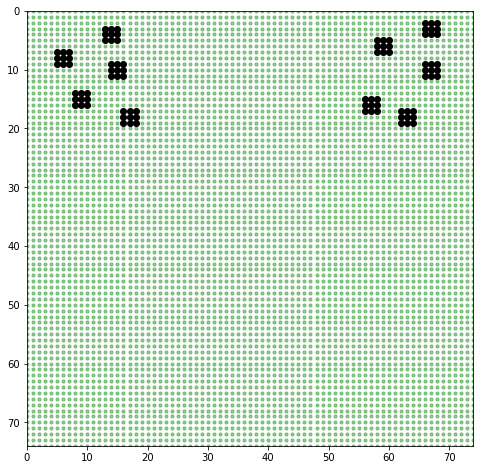

In [97]:
# Debug: plot a few levels
for level, config in enumerate(example_level_configurations[:1]):
    
    clusters = generate_level_clusters(config, {})
    
    configs = [c["config"] for c in clusters]
    pp.pprint(configs)
    
    objects = list(itertools.chain.from_iterable([c["objects"] for c in clusters]))
    pp.pprint(objects)
    plt.figure(figsize=(8,8))
    plot_objects(objects, range(0, 75))

## Full round configurations

In [98]:
example_gameplay_config = {
    "name": "EXAMPLE - NOT FOR REAL USE",
    "level_duration_seconds": 10,
    "max_abs_value": 10,
    "min_abs_value": 1,
    "grid_size": 75, # how many effective squares you want to play with
    "player_size": 5,
    "object_size": 4,
    "object_padding": 6,
    "ratio_negative_to_zero": .5
}

In [99]:
def generate_levels(global_gameplay_config, level_config_list):
    
    generated_levels = []
    
    for i, level_configuration in enumerate(level_config_list):
        new_level = {"game_metadata": copy.deepcopy(global_gameplay_config)}
        # probably paranoid, but I like UUIDs...
        new_level["game_metadata"]["uuid"] = str(uuid.uuid4())
        new_level["game_metadata"]["level_number"] = i+1
        
        new_level_clusters = generate_level_clusters(level_configuration, global_gameplay_config)
        
        # Add cluster configuration list into level config
        new_level["game_metadata"]["max_cluster_value"] = max([c["config"]["actual_positive_value"] for c in new_level_clusters])
        new_level["game_metadata"]["cluster_configs"] = [c["config"] for c in new_level_clusters]
        
        # Place player in center for now
        player = {"x": int(global_gameplay_config["grid_size"] / 2) + 1, 
                  "y": int(global_gameplay_config["grid_size"] / 2) + 1}
        
        # Unroll objects from cluster list
        objects = list(itertools.chain.from_iterable([c["objects"] for c in new_level_clusters]))
        
        new_level["frame_data"] = {
            "objects": objects,
            "player": player,
            "score": 0,
            "ms_elapsed": 0
        }
        
        generated_levels.append(new_level)
    
    return generated_levels

def update_cluster_config_values(level_configuration):
    
    for l in level_configuration:

        cluster_config_list = l["game_metadata"]["cluster_configs"]
        object_list = l["frame_data"]["objects"]
        
        print("Checking Level {}".format( l["game_metadata"]["level_number"]))
        
        for c in cluster_config_list:

            # Delete hanging metadata we don't wany anymore (can get stale)
            if "starting_objects" in c.keys():
                print("\tDELETING 'starting objects' from cluster {}".format(c["id"]))
                del c["starting_objects"]

            objects = [o for o in object_list if o["cluster_id"] == c["id"]]
            pos_objects = [v["value"] for v in objects if v["value"] > 0]
            new_pos_value = sum(pos_objects)
            
            if c["actual_positive_value"] != new_pos_value:
                print("\tUPDATING: cluster {}, {} to {}".format(
                   c["id"], c["actual_positive_value"], new_pos_value))
            
            # Re-calculate each cluster's +/- values
            c["actual_positive_value"] = new_pos_value
            c["actual_negative_value"] = sum([v["value"] for v in objects if v["value"] < 0])
    
        # Update our level-metadata tracking
        new_max_cluster_value = max([c["actual_positive_value"] for c in cluster_config_list])
        if new_max_cluster_value != l["game_metadata"]["max_cluster_value"]:
            
            print("\tUPDATING: level {}, max cluster value {} to {}".format(
                l["game_metadata"]["level_number"], l["game_metadata"]["max_cluster_value"],
                new_max_cluster_value))
            
            l["game_metadata"]["max_cluster_value"] = new_max_cluster_value           

## Plotting

In [100]:
def plot_control(object_list, **kwargs):
    return plot_object_layout(object_list, ['r', 'w', 'g'], 
                              positive_shape="s", label_values="mask_value", plot_fake_colors=False, max_obj_value=1,
                              **kwargs)

def plot_object_layout(original_object_list, object_colormap, positive_shape='o', negative_shape='s', zero_shape=None, 
                       color_magnitude=False, plot_x=5, plot_y=5, title="", label_values=None, max_obj_value=10, plot_fake_colors=True, ax=None):    

    object_list = copy.deepcopy(original_object_list)
    
    for o in object_list:
        o["true_value"] = o.get('value')

    objects_df = pd.DataFrame(object_list)

    objects_df["mask_value"] = objects_df.mask_value
    min_obj_value = -max_obj_value
    
    if ax is None:
        plt.figure(figsize=(plot_x, plot_y))
        ax = plt.gca()
    
    ax.set_facecolor('k')

    ax.scatter(38, 38, s=300, marker='*', color='b')

    colormap_for_plot = LinearSegmentedColormap.from_list("val_cmap", object_colormap)
    
    pos_objects = objects_df[objects_df.true_value > 0]
    ax.scatter(pos_objects.x, pos_objects.y, s=400, marker=positive_shape,
                c=pos_objects.true_value, cmap=colormap_for_plot, vmin=min_obj_value, vmax=max_obj_value)

    neg_objects = objects_df[objects_df.true_value < 0]
    ax.scatter(neg_objects.x, neg_objects.y, s=400, marker=negative_shape,
                c=neg_objects.true_value, cmap=colormap_for_plot, vmin=min_obj_value, vmax=max_obj_value)

        
    if label_values:
        for index, row in objects_df.iterrows():
            ax.text(row["x"]-1, row["y"]+.5, int(row[label_values]), weight='bold')
                
    ax.set_xlim(0, 75)
    ax.set_ylim(75,0)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(title)


## Generating Practice Levels

In [101]:
practice_gameplay_config = {
    "name": "boolean1.0_practice",
    "level_duration_seconds": 8,
    "max_abs_value": 10,
    "min_abs_value": 1,
    "grid_size": 75, # how many effective squares you want to play with
    "player_size": 5,
    "object_size": 3,
    "object_padding": 7,
    "cluster_width": 20,
    "ratio_negative_to_zero": .7,
}

practice_level_configs = [
    
    # Note that these *explicitly* place clusters next to each other to avoid
    # revealing cluster-nature of gameplay
    
    # LEVEL 1: TWO CLUSTERS, ALL POSITIVE
    [{
        "centroid": TOP_LEFT,
        "pos_objects": 4,
        "num_objects": 4
    }, {
        "centroid": TOP_RIGHT,
        "pos_objects": 3,
        "num_objects": 3,
    }],
    
    # LEVEL 2: NEGATIVES
    [{
        "centroid": TOP_LEFT,
        "pos_objects": 2,
        "num_objects": 5,
    }, {
        "centroid": BOTTOM_LEFT,
        "pos_objects": 2,
        "num_objects": 5,
    }],
    
    # LEVEL 3: NEGATIVES (+ applied mask)
    [{
        "centroid": TOP_LEFT,
        "pos_objects": 3,
        "num_objects": 5
    }, {
        "centroid": BOTTOM_RIGHT,
        "pos_objects": 2,
        "num_objects": 5,
    }],
    
    # LEVEL 4: Full simulated level play
    [{
        "centroid": TOP_LEFT,
        "pos_objects": 3,
        "num_objects": 5
    }, {
        "centroid": TOP_RIGHT,
        "pos_objects": 3,
        "num_objects": 5,
    }, {
        "centroid": BOTTOM_RIGHT,
        "pos_objects": 5,
        "num_objects": 5,
    }, {
        "centroid": BOTTOM_LEFT,
        "pos_objects": 2,
        "num_objects": 5,
    }]
]

### Generate new practice levels *or* view current ones

In [102]:
practice_levels_to_plot = generate_levels(practice_gameplay_config, practice_level_configs)

In [103]:
practice_levels_to_plot

[{'game_metadata': {'name': 'boolean1.0_practice',
   'level_duration_seconds': 8,
   'max_abs_value': 10,
   'min_abs_value': 1,
   'grid_size': 75,
   'player_size': 5,
   'object_size': 3,
   'object_padding': 7,
   'cluster_width': 20,
   'ratio_negative_to_zero': 0.7,
   'uuid': 'a963e3d3-2a88-4ee4-81e3-f21da22bdee9',
   'level_number': 1,
   'max_cluster_value': 4,
   'cluster_configs': [{'centroid': (11, 11),
     'pos_objects': 4,
     'num_objects': 4,
     'id': 1,
     'actual_positive_value': 4,
     'actual_negative_value': 0},
    {'centroid': (64, 11),
     'pos_objects': 3,
     'num_objects': 3,
     'id': 2,
     'actual_positive_value': 3,
     'actual_negative_value': 0}]},
  'frame_data': {'objects': [{'x': 17,
     'y': 5,
     'value': 1,
     'mask_value': 1,
     'cluster_id': 1},
    {'x': 8, 'y': 15, 'value': 1, 'mask_value': 1, 'cluster_id': 1},
    {'x': 5, 'y': 8, 'value': 1, 'mask_value': 1, 'cluster_id': 1},
    {'x': 15, 'y': 14, 'value': 1, 'mask_value

In [19]:
hex_red = "0xFF0000"
hex_blue = "0x0000FF"
hex_green = "0x00FF00"
hex_gray = "0x555555"

circle = "blankCircle"
square = "blankSquare"

def practice_mask(o):
    
    if o["value"] == 1:
        o["objectTint"] = hex_blue
        o["objectShape"] = circle
    else:
        o["objectTint"] = hex_red
        o["objectShape"] = square
        
def no_mask(o):
    
    o["objectTint"] = hex_gray
    o["objectShape"] = square
    
for i, l in enumerate(practice_levels_to_plot):
    
    objects = l["frame_data"]["objects"]
    
    for o in objects:
        if i in [0, 1]:
            no_mask(o)
        else:
            practice_mask(o)
            
print(practice_levels_to_plot[0]["frame_data"]["objects"])

[{'x': 16, 'y': 16, 'value': 1, 'mask_value': 1, 'cluster_id': 1, 'objectTint': '0x555555', 'objectShape': 'blankSquare'}, {'x': 5, 'y': 3, 'value': 1, 'mask_value': 1, 'cluster_id': 1, 'objectTint': '0x555555', 'objectShape': 'blankSquare'}, {'x': 4, 'y': 12, 'value': 1, 'mask_value': 0, 'cluster_id': 1, 'objectTint': '0x555555', 'objectShape': 'blankSquare'}, {'x': 16, 'y': 7, 'value': 1, 'mask_value': 1, 'cluster_id': 1, 'objectTint': '0x555555', 'objectShape': 'blankSquare'}, {'x': 64, 'y': 16, 'value': 1, 'mask_value': 0, 'cluster_id': 2, 'objectTint': '0x555555', 'objectShape': 'blankSquare'}, {'x': 70, 'y': 7, 'value': 1, 'mask_value': 3, 'cluster_id': 2, 'objectTint': '0x555555', 'objectShape': 'blankSquare'}, {'x': 57, 'y': 7, 'value': 1, 'mask_value': 3, 'cluster_id': 2, 'objectTint': '0x555555', 'objectShape': 'blankSquare'}]


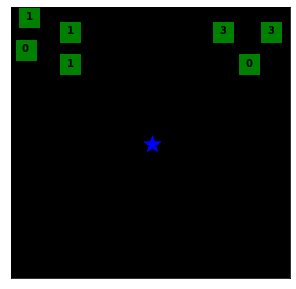

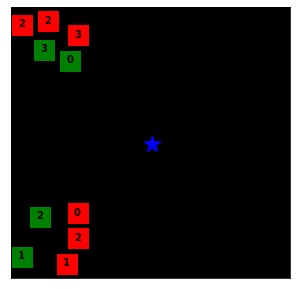

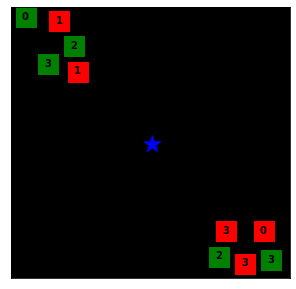

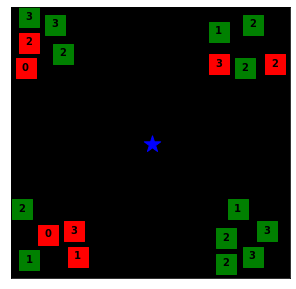

In [20]:
for l in practice_levels_to_plot:
    plot_control(l["frame_data"]["objects"], plot_x=5, plot_y=5)

In [21]:
update_cluster_config_values(practice_levels_to_plot)

json.dumps(practice_levels_to_plot)

Checking Level 1
Checking Level 2
Checking Level 3
Checking Level 4


'[{"game_metadata": {"name": "boolean1.0_practice", "level_duration_seconds": 8, "max_abs_value": 10, "min_abs_value": 1, "grid_size": 75, "player_size": 5, "object_size": 3, "object_padding": 7, "cluster_width": 20, "ratio_negative_to_zero": 0.7, "uuid": "e908dc4e-55a8-488e-ac58-f311bcb21b37", "level_number": 1, "max_cluster_value": 4, "cluster_configs": [{"centroid": [11, 11], "pos_objects": 4, "num_objects": 4, "id": 1, "actual_positive_value": 4, "actual_negative_value": 0}, {"centroid": [64, 11], "pos_objects": 3, "num_objects": 3, "id": 2, "actual_positive_value": 3, "actual_negative_value": 0}]}, "frame_data": {"objects": [{"x": 16, "y": 16, "value": 1, "mask_value": 1, "cluster_id": 1, "objectTint": "0x555555", "objectShape": "blankSquare"}, {"x": 5, "y": 3, "value": 1, "mask_value": 1, "cluster_id": 1, "objectTint": "0x555555", "objectShape": "blankSquare"}, {"x": 4, "y": 12, "value": 1, "mask_value": 0, "cluster_id": 1, "objectTint": "0x555555", "objectShape": "blankSquare"},

## Generating Actual Levels

In [22]:
actual_gameplay_config = {
    "name": "boolean_1.0",
    "level_duration_seconds": 8,
    "grid_size": 75, # how many effective squares you want to play with
    "player_size": 5,
    "object_size": 3,
    "object_padding": 7,
    "cluster_width": 20,
}

In [23]:
def generate_random_level(distribution=None, random_state=None):
    
    centroids = [TOP_LEFT, TOP_RIGHT, BOTTOM_RIGHT, BOTTOM_LEFT]
    if distribution is None:
        values = [random.choice(range(0,6)) for i in range(0, len(centroids))]
    else:
        values = distribution.rvs(size=len(centroids))
        values = [int(round(max(0, min(x, 5)))) for x in array]

    return [{"centroid": c, "num_objects": 5, "pos_objects": v} for c, v in zip(centroids, values)]

# Examine Old Levels / Generate New Ones

In [24]:
existing_levels = [ { 'frame_data': { 'ms_elapsed': 0,
                    'objects': [ { 'cluster_id': 1,
                                   'mask_value': 1,
                                   'value': 1,
                                   'x': 5,
                                   'y': 3},
                                 { 'cluster_id': 1,
                                   'mask_value': 0,
                                   'value': 1,
                                   'x': 10,
                                   'y': 14},
                                 { 'cluster_id': 1,
                                   'mask_value': 3,
                                   'value': 1,
                                   'x': 18,
                                   'y': 13},
                                 { 'cluster_id': 1,
                                   'mask_value': 3,
                                   'value': 1,
                                   'x': 3,
                                   'y': 12},
                                 { 'cluster_id': 1,
                                   'mask_value': 0,
                                   'value': -1,
                                   'x': 14,
                                   'y': 4},
                                 { 'cluster_id': 2,
                                   'mask_value': 1,
                                   'value': 1,
                                   'x': 68,
                                   'y': 10},
                                 { 'cluster_id': 2,
                                   'mask_value': 0,
                                   'value': 1,
                                   'x': 61,
                                   'y': 5},
                                 { 'cluster_id': 2,
                                   'mask_value': 3,
                                   'value': 1,
                                   'x': 66,
                                   'y': 17},
                                 { 'cluster_id': 2,
                                   'mask_value': 2,
                                   'value': -1,
                                   'x': 58,
                                   'y': 13},
                                 { 'cluster_id': 2,
                                   'mask_value': 0,
                                   'value': -1,
                                   'x': 71,
                                   'y': 3},
                                 { 'cluster_id': 3,
                                   'mask_value': 2,
                                   'value': 1,
                                   'x': 63,
                                   'y': 65},
                                 { 'cluster_id': 3,
                                   'mask_value': 1,
                                   'value': -1,
                                   'x': 71,
                                   'y': 64},
                                 { 'cluster_id': 3,
                                   'mask_value': 2,
                                   'value': -1,
                                   'x': 56,
                                   'y': 71},
                                 { 'cluster_id': 3,
                                   'mask_value': 1,
                                   'value': -1,
                                   'x': 64,
                                   'y': 56},
                                 { 'cluster_id': 3,
                                   'mask_value': 1,
                                   'value': -1,
                                   'x': 56,
                                   'y': 64},
                                 { 'cluster_id': 4,
                                   'mask_value': 2,
                                   'value': 1,
                                   'x': 10,
                                   'y': 70},
                                 { 'cluster_id': 4,
                                   'mask_value': 3,
                                   'value': 1,
                                   'x': 7,
                                   'y': 60},
                                 { 'cluster_id': 4,
                                   'mask_value': 3,
                                   'value': 1,
                                   'x': 18,
                                   'y': 70},
                                 { 'cluster_id': 4,
                                   'mask_value': 0,
                                   'value': 1,
                                   'x': 16,
                                   'y': 62},
                                 { 'cluster_id': 4,
                                   'mask_value': 0,
                                   'value': -1,
                                   'x': 3,
                                   'y': 70}],
                    'player': {'x': 38, 'y': 38},
                    'score': 0},
    'game_metadata': { 'cluster_configs': [ { 'actual_negative_value': -1,
                                              'actual_positive_value': 4,
                                              'centroid': (11, 11),
                                              'id': 1,
                                              'num_objects': 5,
                                              'pos_objects': 4},
                                            { 'actual_negative_value': -2,
                                              'actual_positive_value': 3,
                                              'centroid': (64, 11),
                                              'id': 2,
                                              'num_objects': 5,
                                              'pos_objects': 3},
                                            { 'actual_negative_value': -4,
                                              'actual_positive_value': 1,
                                              'centroid': (64, 64),
                                              'id': 3,
                                              'num_objects': 5,
                                              'pos_objects': 1},
                                            { 'actual_negative_value': -1,
                                              'actual_positive_value': 4,
                                              'centroid': (11, 64),
                                              'id': 4,
                                              'num_objects': 5,
                                              'pos_objects': 4}],
                       'cluster_width': 20,
                       'grid_size': 75,
                       'level_duration_seconds': 8,
                       'level_number': 1,
                       'max_cluster_value': 4,
                       'name': 'boolean_1.0',
                       'object_padding': 7,
                       'object_size': 3,
                       'player_size': 5,
                       'uuid': 'a419773b-19e6-460d-848a-0ecf2ab477dc'}},
  { 'frame_data': { 'ms_elapsed': 0,
                    'objects': [ { 'cluster_id': 1,
                                   'mask_value': 3,
                                   'value': 1,
                                   'x': 17,
                                   'y': 18},
                                 { 'cluster_id': 1,
                                   'mask_value': 1,
                                   'value': 1,
                                   'x': 12,
                                   'y': 9},
                                 { 'cluster_id': 1,
                                   'mask_value': 3,
                                   'value': 1,
                                   'x': 5,
                                   'y': 10},
                                 { 'cluster_id': 1,
                                   'mask_value': 3,
                                   'value': -1,
                                   'x': 6,
                                   'y': 18},
                                 { 'cluster_id': 1,
                                   'mask_value': 2,
                                   'value': -1,
                                   'x': 4,
                                   'y': 3},
                                 { 'cluster_id': 2,
                                   'mask_value': 0,
                                   'value': 1,
                                   'x': 62,
                                   'y': 11},
                                 { 'cluster_id': 2,
                                   'mask_value': 0,
                                   'value': 1,
                                   'x': 60,
                                   'y': 4},
                                 { 'cluster_id': 2,
                                   'mask_value': 0,
                                   'value': 1,
                                   'x': 69,
                                   'y': 13},
                                 { 'cluster_id': 2,
                                   'mask_value': 3,
                                   'value': 1,
                                   'x': 68,
                                   'y': 3},
                                 { 'cluster_id': 2,
                                   'mask_value': 0,
                                   'value': -1,
                                   'x': 58,
                                   'y': 18},
                                 { 'cluster_id': 3,
                                   'mask_value': 0,
                                   'value': 1,
                                   'x': 62,
                                   'y': 66},
                                 { 'cluster_id': 3,
                                   'mask_value': 1,
                                   'value': 1,
                                   'x': 63,
                                   'y': 59},
                                 { 'cluster_id': 3,
                                   'mask_value': 3,
                                   'value': 1,
                                   'x': 71,
                                   'y': 62},
                                 { 'cluster_id': 3,
                                   'mask_value': 0,
                                   'value': 1,
                                   'x': 56,
                                   'y': 58},
                                 { 'cluster_id': 3,
                                   'mask_value': 1,
                                   'value': 1,
                                   'x': 71,
                                   'y': 70},
                                 { 'cluster_id': 4,
                                   'mask_value': 0,
                                   'value': -1,
                                   'x': 15,
                                   'y': 61},
                                 { 'cluster_id': 4,
                                   'mask_value': 3,
                                   'value': -1,
                                   'x': 5,
                                   'y': 60},
                                 { 'cluster_id': 4,
                                   'mask_value': 0,
                                   'value': -1,
                                   'x': 11,
                                   'y': 68},
                                 { 'cluster_id': 4,
                                   'mask_value': 3,
                                   'value': -1,
                                   'x': 18,
                                   'y': 71},
                                 { 'cluster_id': 4,
                                   'mask_value': 3,
                                   'value': -1,
                                   'x': 3,
                                   'y': 68}],
                    'player': {'x': 38, 'y': 38},
                    'score': 0},
    'game_metadata': { 'cluster_configs': [ { 'actual_negative_value': -2,
                                              'actual_positive_value': 3,
                                              'centroid': (11, 11),
                                              'id': 1,
                                              'num_objects': 5,
                                              'pos_objects': 3},
                                            { 'actual_negative_value': -1,
                                              'actual_positive_value': 4,
                                              'centroid': (64, 11),
                                              'id': 2,
                                              'num_objects': 5,
                                              'pos_objects': 4},
                                            { 'actual_negative_value': 0,
                                              'actual_positive_value': 5,
                                              'centroid': (64, 64),
                                              'id': 3,
                                              'num_objects': 5,
                                              'pos_objects': 5},
                                            { 'actual_negative_value': -5,
                                              'actual_positive_value': 0,
                                              'centroid': (11, 64),
                                              'id': 4,
                                              'num_objects': 5,
                                              'pos_objects': 0}],
                       'cluster_width': 20,
                       'grid_size': 75,
                       'level_duration_seconds': 8,
                       'level_number': 2,
                       'max_cluster_value': 5,
                       'name': 'boolean_1.0',
                       'object_padding': 7,
                       'object_size': 3,
                       'player_size': 5,
                       'uuid': '16fa8542-d5ca-4189-a6f9-7effd8b3aa4d'}},
  { 'frame_data': { 'ms_elapsed': 0,
                    'objects': [ { 'cluster_id': 1,
                                   'mask_value': 3,
                                   'value': 1,
                                   'x': 4,
                                   'y': 6},
                                 { 'cluster_id': 1,
                                   'mask_value': 0,
                                   'value': 1,
                                   'x': 12,
                                   'y': 3},
                                 { 'cluster_id': 1,
                                   'mask_value': 1,
                                   'value': 1,
                                   'x': 16,
                                   'y': 11},
                                 { 'cluster_id': 1,
                                   'mask_value': 1,
                                   'value': -1,
                                   'x': 6,
                                   'y': 14},
                                 { 'cluster_id': 1,
                                   'mask_value': 0,
                                   'value': -1,
                                   'x': 13,
                                   'y': 18},
                                 { 'cluster_id': 2,
                                   'mask_value': 2,
                                   'value': 1,
                                   'x': 58,
                                   'y': 10},
                                 { 'cluster_id': 2,
                                   'mask_value': 3,
                                   'value': 1,
                                   'x': 66,
                                   'y': 10},
                                 { 'cluster_id': 2,
                                   'mask_value': 0,
                                   'value': -1,
                                   'x': 60,
                                   'y': 17},
                                 { 'cluster_id': 2,
                                   'mask_value': 2,
                                   'value': -1,
                                   'x': 65,
                                   'y': 3},
                                 { 'cluster_id': 2,
                                   'mask_value': 3,
                                   'value': -1,
                                   'x': 56,
                                   'y': 3},
                                 { 'cluster_id': 3,
                                   'mask_value': 3,
                                   'value': 1,
                                   'x': 63,
                                   'y': 57},
                                 { 'cluster_id': 3,
                                   'mask_value': 3,
                                   'value': 1,
                                   'x': 65,
                                   'y': 71},
                                 { 'cluster_id': 3,
                                   'mask_value': 1,
                                   'value': -1,
                                   'x': 57,
                                   'y': 66},
                                 { 'cluster_id': 3,
                                   'mask_value': 2,
                                   'value': -1,
                                   'x': 70,
                                   'y': 56},
                                 { 'cluster_id': 3,
                                   'mask_value': 3,
                                   'value': -1,
                                   'x': 69,
                                   'y': 64},
                                 { 'cluster_id': 4,
                                   'mask_value': 0,
                                   'value': 1,
                                   'x': 15,
                                   'y': 64},
                                 { 'cluster_id': 4,
                                   'mask_value': 3,
                                   'value': 1,
                                   'x': 12,
                                   'y': 71},
                                 { 'cluster_id': 4,
                                   'mask_value': 2,
                                   'value': 1,
                                   'x': 17,
                                   'y': 57},
                                 { 'cluster_id': 4,
                                   'mask_value': 2,
                                   'value': 1,
                                   'x': 5,
                                   'y': 61},
                                 { 'cluster_id': 4,
                                   'mask_value': 0,
                                   'value': -1,
                                   'x': 4,
                                   'y': 71}],
                    'player': {'x': 38, 'y': 38},
                    'score': 0},
    'game_metadata': { 'cluster_configs': [ { 'actual_negative_value': -2,
                                              'actual_positive_value': 3,
                                              'centroid': (11, 11),
                                              'id': 1,
                                              'num_objects': 5,
                                              'pos_objects': 3},
                                            { 'actual_negative_value': -3,
                                              'actual_positive_value': 2,
                                              'centroid': (64, 11),
                                              'id': 2,
                                              'num_objects': 5,
                                              'pos_objects': 2},
                                            { 'actual_negative_value': -3,
                                              'actual_positive_value': 2,
                                              'centroid': (64, 64),
                                              'id': 3,
                                              'num_objects': 5,
                                              'pos_objects': 2},
                                            { 'actual_negative_value': -1,
                                              'actual_positive_value': 4,
                                              'centroid': (11, 64),
                                              'id': 4,
                                              'num_objects': 5,
                                              'pos_objects': 4}],
                       'cluster_width': 20,
                       'grid_size': 75,
                       'level_duration_seconds': 8,
                       'level_number': 3,
                       'max_cluster_value': 4,
                       'name': 'boolean_1.0',
                       'object_padding': 7,
                       'object_size': 3,
                       'player_size': 5,
                       'uuid': 'ad10cd70-85ae-43fc-9ef5-dfc4d5546d2c'}},
  { 'frame_data': { 'ms_elapsed': 0,
                    'objects': [ { 'cluster_id': 1,
                                   'mask_value': 1,
                                   'value': 1,
                                   'x': 7,
                                   'y': 14},
                                 { 'cluster_id': 1,
                                   'mask_value': 1,
                                   'value': 1,
                                   'x': 4,
                                   'y': 3},
                                 { 'cluster_id': 1,
                                   'mask_value': 0,
                                   'value': 1,
                                   'x': 17,
                                   'y': 3},
                                 { 'cluster_id': 1,
                                   'mask_value': 3,
                                   'value': -1,
                                   'x': 18,
                                   'y': 17},
                                 { 'cluster_id': 1,
                                   'mask_value': 0,
                                   'value': -1,
                                   'x': 18,
                                   'y': 10},
                                 { 'cluster_id': 2,
                                   'mask_value': 1,
                                   'value': 1,
                                   'x': 64,
                                   'y': 15},
                                 { 'cluster_id': 2,
                                   'mask_value': 3,
                                   'value': 1,
                                   'x': 63,
                                   'y': 7},
                                 { 'cluster_id': 2,
                                   'mask_value': 3,
                                   'value': 1,
                                   'x': 56,
                                   'y': 9},
                                 { 'cluster_id': 2,
                                   'mask_value': 3,
                                   'value': 1,
                                   'x': 71,
                                   'y': 17},
                                 { 'cluster_id': 2,
                                   'mask_value': 0,
                                   'value': -1,
                                   'x': 57,
                                   'y': 16},
                                 { 'cluster_id': 3,
                                   'mask_value': 3,
                                   'value': 1,
                                   'x': 71,
                                   'y': 67},
                                 { 'cluster_id': 3,
                                   'mask_value': 3,
                                   'value': 1,
                                   'x': 63,
                                   'y': 59},
                                 { 'cluster_id': 3,
                                   'mask_value': 2,
                                   'value': -1,
                                   'x': 70,
                                   'y': 58},
                                 { 'cluster_id': 3,
                                   'mask_value': 0,
                                   'value': -1,
                                   'x': 59,
                                   'y': 68},
                                 { 'cluster_id': 3,
                                   'mask_value': 0,
                                   'value': -1,
                                   'x': 56,
                                   'y': 58},
                                 { 'cluster_id': 4,
                                   'mask_value': 3,
                                   'value': -1,
                                   'x': 8,
                                   'y': 70},
                                 { 'cluster_id': 4,
                                   'mask_value': 2,
                                   'value': -1,
                                   'x': 10,
                                   'y': 56},
                                 { 'cluster_id': 4,
                                   'mask_value': 3,
                                   'value': -1,
                                   'x': 3,
                                   'y': 56},
                                 { 'cluster_id': 4,
                                   'mask_value': 0,
                                   'value': -1,
                                   'x': 15,
                                   'y': 67},
                                 { 'cluster_id': 4,
                                   'mask_value': 0,
                                   'value': -1,
                                   'x': 17,
                                   'y': 60}],
                    'player': {'x': 38, 'y': 38},
                    'score': 0},
    'game_metadata': { 'cluster_configs': [ { 'actual_negative_value': -2,
                                              'actual_positive_value': 3,
                                              'centroid': (11, 11),
                                              'id': 1,
                                              'num_objects': 5,
                                              'pos_objects': 3},
                                            { 'actual_negative_value': -1,
                                              'actual_positive_value': 4,
                                              'centroid': (64, 11),
                                              'id': 2,
                                              'num_objects': 5,
                                              'pos_objects': 4},
                                            { 'actual_negative_value': -3,
                                              'actual_positive_value': 2,
                                              'centroid': (64, 64),
                                              'id': 3,
                                              'num_objects': 5,
                                              'pos_objects': 2},
                                            { 'actual_negative_value': -5,
                                              'actual_positive_value': 0,
                                              'centroid': (11, 64),
                                              'id': 4,
                                              'num_objects': 5,
                                              'pos_objects': 0}],
                       'cluster_width': 20,
                       'grid_size': 75,
                       'level_duration_seconds': 8,
                       'level_number': 4,
                       'max_cluster_value': 4,
                       'name': 'boolean_1.0',
                       'object_padding': 7,
                       'object_size': 3,
                       'player_size': 5,
                       'uuid': '5cf7b32d-7b64-471b-a465-b4ff95e12729'}},
  { 'frame_data': { 'ms_elapsed': 0,
                    'objects': [ { 'cluster_id': 1,
                                   'mask_value': 2,
                                   'value': 1,
                                   'x': 17,
                                   'y': 10},
                                 { 'cluster_id': 1,
                                   'mask_value': 1,
                                   'value': 1,
                                   'x': 6,
                                   'y': 18},
                                 { 'cluster_id': 1,
                                   'mask_value': 1,
                                   'value': -1,
                                   'x': 6,
                                   'y': 8},
                                 { 'cluster_id': 1,
                                   'mask_value': 2,
                                   'value': -1,
                                   'x': 16,
                                   'y': 17},
                                 { 'cluster_id': 1,
                                   'mask_value': 3,
                                   'value': -1,
                                   'x': 16,
                                   'y': 3},
                                 { 'cluster_id': 2,
                                   'mask_value': 3,
                                   'value': 1,
                                   'x': 61,
                                   'y': 14},
                                 { 'cluster_id': 2,
                                   'mask_value': 2,
                                   'value': 1,
                                   'x': 63,
                                   'y': 5},
                                 { 'cluster_id': 2,
                                   'mask_value': 1,
                                   'value': 1,
                                   'x': 71,
                                   'y': 16},
                                 { 'cluster_id': 2,
                                   'mask_value': 3,
                                   'value': 1,
                                   'x': 56,
                                   'y': 4},
                                 { 'cluster_id': 2,
                                   'mask_value': 1,
                                   'value': 1,
                                   'x': 70,
                                   'y': 9},
                                 { 'cluster_id': 3,
                                   'mask_value': 3,
                                   'value': 1,
                                   'x': 61,
                                   'y': 67},
                                 { 'cluster_id': 3,
                                   'mask_value': 3,
                                   'value': 1,
                                   'x': 70,
                                   'y': 56},
                                 { 'cluster_id': 3,
                                   'mask_value': 3,
                                   'value': 1,
                                   'x': 70,
                                   'y': 70},
                                 { 'cluster_id': 3,
                                   'mask_value': 3,
                                   'value': -1,
                                   'x': 61,
                                   'y': 57},
                                 { 'cluster_id': 3,
                                   'mask_value': 3,
                                   'value': -1,
                                   'x': 68,
                                   'y': 63},
                                 { 'cluster_id': 4,
                                   'mask_value': 2,
                                   'value': -1,
                                   'x': 3,
                                   'y': 71},
                                 { 'cluster_id': 4,
                                   'mask_value': 2,
                                   'value': -1,
                                   'x': 16,
                                   'y': 61},
                                 { 'cluster_id': 4,
                                   'mask_value': 3,
                                   'value': -1,
                                   'x': 8,
                                   'y': 64},
                                 { 'cluster_id': 4,
                                   'mask_value': 2,
                                   'value': -1,
                                   'x': 12,
                                   'y': 71},
                                 { 'cluster_id': 4,
                                   'mask_value': 1,
                                   'value': -1,
                                   'x': 6,
                                   'y': 57}],
                    'player': {'x': 38, 'y': 38},
                    'score': 0},
    'game_metadata': { 'cluster_configs': [ { 'actual_negative_value': -3,
                                              'actual_positive_value': 2,
                                              'centroid': (11, 11),
                                              'id': 1,
                                              'num_objects': 5,
                                              'pos_objects': 2},
                                            { 'actual_negative_value': 0,
                                              'actual_positive_value': 5,
                                              'centroid': (64, 11),
                                              'id': 2,
                                              'num_objects': 5,
                                              'pos_objects': 5},
                                            { 'actual_negative_value': -2,
                                              'actual_positive_value': 3,
                                              'centroid': (64, 64),
                                              'id': 3,
                                              'num_objects': 5,
                                              'pos_objects': 3},
                                            { 'actual_negative_value': -5,
                                              'actual_positive_value': 0,
                                              'centroid': (11, 64),
                                              'id': 4,
                                              'num_objects': 5,
                                              'pos_objects': 0}],
                       'cluster_width': 20,
                       'grid_size': 75,
                       'level_duration_seconds': 8,
                       'level_number': 5,
                       'max_cluster_value': 5,
                       'name': 'boolean_1.0',
                       'object_padding': 7,
                       'object_size': 3,
                       'player_size': 5,
                       'uuid': '33e3949a-99f3-4298-bf73-7a207df5f9ef'}},
  { 'frame_data': { 'ms_elapsed': 0,
                    'objects': [ { 'cluster_id': 1,
                                   'mask_value': 3,
                                   'value': 1,
                                   'x': 18,
                                   'y': 8},
                                 { 'cluster_id': 1,
                                   'mask_value': 3,
                                   'value': 1,
                                   'x': 8,
                                   'y': 12},
                                 { 'cluster_id': 1,
                                   'mask_value': 3,
                                   'value': -1,
                                   'x': 10,
                                   'y': 3},
                                 { 'cluster_id': 1,
                                   'mask_value': 1,
                                   'value': -1,
                                   'x': 3,
                                   'y': 3},
                                 { 'cluster_id': 1,
                                   'mask_value': 1,
                                   'value': -1,
                                   'x': 18,
                                   'y': 15},
                                 { 'cluster_id': 2,
                                   'mask_value': 2,
                                   'value': 1,
                                   'x': 60,
                                   'y': 13},
                                 { 'cluster_id': 2,
                                   'mask_value': 3,
                                   'value': -1,
                                   'x': 67,
                                   'y': 17},
                                 { 'cluster_id': 2,
                                   'mask_value': 3,
                                   'value': -1,
                                   'x': 58,
                                   'y': 5},
                                 { 'cluster_id': 2,
                                   'mask_value': 3,
                                   'value': -1,
                                   'x': 67,
                                   'y': 3},
                                 { 'cluster_id': 2,
                                   'mask_value': 3,
                                   'value': -1,
                                   'x': 69,
                                   'y': 10},
                                 { 'cluster_id': 3,
                                   'mask_value': 1,
                                   'value': 1,
                                   'x': 69,
                                   'y': 69},
                                 { 'cluster_id': 3,
                                   'mask_value': 2,
                                   'value': 1,
                                   'x': 56,
                                   'y': 63},
                                 { 'cluster_id': 3,
                                   'mask_value': 2,
                                   'value': 1,
                                   'x': 56,
                                   'y': 56},
                                 { 'cluster_id': 3,
                                   'mask_value': 3,
                                   'value': -1,
                                   'x': 61,
                                   'y': 70},
                                 { 'cluster_id': 3,
                                   'mask_value': 2,
                                   'value': -1,
                                   'x': 63,
                                   'y': 58},
                                 { 'cluster_id': 4,
                                   'mask_value': 2,
                                   'value': 1,
                                   'x': 3,
                                   'y': 64},
                                 { 'cluster_id': 4,
                                   'mask_value': 1,
                                   'value': 1,
                                   'x': 15,
                                   'y': 68},
                                 { 'cluster_id': 4,
                                   'mask_value': 1,
                                   'value': 1,
                                   'x': 10,
                                   'y': 56},
                                 { 'cluster_id': 4,
                                   'mask_value': 3,
                                   'value': -1,
                                   'x': 18,
                                   'y': 61},
                                 { 'cluster_id': 4,
                                   'mask_value': 0,
                                   'value': -1,
                                   'x': 6,
                                   'y': 71}],
                    'player': {'x': 38, 'y': 38},
                    'score': 0},
    'game_metadata': { 'cluster_configs': [ { 'actual_negative_value': -3,
                                              'actual_positive_value': 2,
                                              'centroid': (11, 11),
                                              'id': 1,
                                              'num_objects': 5,
                                              'pos_objects': 2},
                                            { 'actual_negative_value': -4,
                                              'actual_positive_value': 1,
                                              'centroid': (64, 11),
                                              'id': 2,
                                              'num_objects': 5,
                                              'pos_objects': 1},
                                            { 'actual_negative_value': -2,
                                              'actual_positive_value': 3,
                                              'centroid': (64, 64),
                                              'id': 3,
                                              'num_objects': 5,
                                              'pos_objects': 3},
                                            { 'actual_negative_value': -2,
                                              'actual_positive_value': 3,
                                              'centroid': (11, 64),
                                              'id': 4,
                                              'num_objects': 5,
                                              'pos_objects': 3}],
                       'cluster_width': 20,
                       'grid_size': 75,
                       'level_duration_seconds': 8,
                       'level_number': 6,
                       'max_cluster_value': 3,
                       'name': 'boolean_1.0',
                       'object_padding': 7,
                       'object_size': 3,
                       'player_size': 5,
                       'uuid': '3c8d408f-9b7e-43e0-98ac-751952a57b34'}},
  { 'frame_data': { 'ms_elapsed': 0,
                    'objects': [ { 'cluster_id': 1,
                                   'mask_value': 1,
                                   'value': 1,
                                   'x': 16,
                                   'y': 10},
                                 { 'cluster_id': 1,
                                   'mask_value': 1,
                                   'value': 1,
                                   'x': 9,
                                   'y': 9},
                                 { 'cluster_id': 1,
                                   'mask_value': 3,
                                   'value': 1,
                                   'x': 11,
                                   'y': 18},
                                 { 'cluster_id': 1,
                                   'mask_value': 0,
                                   'value': -1,
                                   'x': 18,
                                   'y': 18},
                                 { 'cluster_id': 1,
                                   'mask_value': 2,
                                   'value': -1,
                                   'x': 3,
                                   'y': 16},
                                 { 'cluster_id': 2,
                                   'mask_value': 1,
                                   'value': 1,
                                   'x': 67,
                                   'y': 18},
                                 { 'cluster_id': 2,
                                   'mask_value': 1,
                                   'value': 1,
                                   'x': 60,
                                   'y': 4},
                                 { 'cluster_id': 2,
                                   'mask_value': 0,
                                   'value': -1,
                                   'x': 59,
                                   'y': 14},
                                 { 'cluster_id': 2,
                                   'mask_value': 3,
                                   'value': -1,
                                   'x': 67,
                                   'y': 3},
                                 { 'cluster_id': 2,
                                   'mask_value': 0,
                                   'value': -1,
                                   'x': 68,
                                   'y': 11},
                                 { 'cluster_id': 3,
                                   'mask_value': 3,
                                   'value': 1,
                                   'x': 57,
                                   'y': 69},
                                 { 'cluster_id': 3,
                                   'mask_value': 2,
                                   'value': 1,
                                   'x': 65,
                                   'y': 63},
                                 { 'cluster_id': 3,
                                   'mask_value': 1,
                                   'value': -1,
                                   'x': 69,
                                   'y': 56},
                                 { 'cluster_id': 3,
                                   'mask_value': 3,
                                   'value': -1,
                                   'x': 56,
                                   'y': 60},
                                 { 'cluster_id': 3,
                                   'mask_value': 3,
                                   'value': -1,
                                   'x': 68,
                                   'y': 71},
                                 { 'cluster_id': 4,
                                   'mask_value': 0,
                                   'value': 1,
                                   'x': 18,
                                   'y': 64},
                                 { 'cluster_id': 4,
                                   'mask_value': 2,
                                   'value': 1,
                                   'x': 8,
                                   'y': 60},
                                 { 'cluster_id': 4,
                                   'mask_value': 1,
                                   'value': 1,
                                   'x': 8,
                                   'y': 69},
                                 { 'cluster_id': 4,
                                   'mask_value': 1,
                                   'value': 1,
                                   'x': 17,
                                   'y': 71},
                                 { 'cluster_id': 4,
                                   'mask_value': 0,
                                   'value': -1,
                                   'x': 17,
                                   'y': 57}],
                    'player': {'x': 38, 'y': 38},
                    'score': 0},
    'game_metadata': { 'cluster_configs': [ { 'actual_negative_value': -2,
                                              'actual_positive_value': 3,
                                              'centroid': (11, 11),
                                              'id': 1,
                                              'num_objects': 5,
                                              'pos_objects': 3},
                                            { 'actual_negative_value': -3,
                                              'actual_positive_value': 2,
                                              'centroid': (64, 11),
                                              'id': 2,
                                              'num_objects': 5,
                                              'pos_objects': 2},
                                            { 'actual_negative_value': -3,
                                              'actual_positive_value': 2,
                                              'centroid': (64, 64),
                                              'id': 3,
                                              'num_objects': 5,
                                              'pos_objects': 2},
                                            { 'actual_negative_value': -1,
                                              'actual_positive_value': 4,
                                              'centroid': (11, 64),
                                              'id': 4,
                                              'num_objects': 5,
                                              'pos_objects': 4}],
                       'cluster_width': 20,
                       'grid_size': 75,
                       'level_duration_seconds': 8,
                       'level_number': 7,
                       'max_cluster_value': 4,
                       'name': 'boolean_1.0',
                       'object_padding': 7,
                       'object_size': 3,
                       'player_size': 5,
                       'uuid': '0af19c54-1ec7-4669-9f8f-17600bf4a047'}},
  { 'frame_data': { 'ms_elapsed': 0,
                    'objects': [ { 'cluster_id': 1,
                                   'mask_value': 1,
                                   'value': 1,
                                   'x': 11,
                                   'y': 17},
                                 { 'cluster_id': 1,
                                   'mask_value': 2,
                                   'value': -1,
                                   'x': 10,
                                   'y': 8},
                                 { 'cluster_id': 1,
                                   'mask_value': 3,
                                   'value': -1,
                                   'x': 17,
                                   'y': 4},
                                 { 'cluster_id': 1,
                                   'mask_value': 1,
                                   'value': -1,
                                   'x': 18,
                                   'y': 17},
                                 { 'cluster_id': 1,
                                   'mask_value': 3,
                                   'value': -1,
                                   'x': 3,
                                   'y': 5},
                                 { 'cluster_id': 2,
                                   'mask_value': 0,
                                   'value': -1,
                                   'x': 65,
                                   'y': 16},
                                 { 'cluster_id': 2,
                                   'mask_value': 2,
                                   'value': -1,
                                   'x': 63,
                                   'y': 3},
                                 { 'cluster_id': 2,
                                   'mask_value': 0,
                                   'value': -1,
                                   'x': 56,
                                   'y': 12},
                                 { 'cluster_id': 2,
                                   'mask_value': 3,
                                   'value': -1,
                                   'x': 71,
                                   'y': 4},
                                 { 'cluster_id': 2,
                                   'mask_value': 1,
                                   'value': -1,
                                   'x': 56,
                                   'y': 5},
                                 { 'cluster_id': 3,
                                   'mask_value': 3,
                                   'value': 1,
                                   'x': 56,
                                   'y': 61},
                                 { 'cluster_id': 3,
                                   'mask_value': 0,
                                   'value': 1,
                                   'x': 57,
                                   'y': 69},
                                 { 'cluster_id': 3,
                                   'mask_value': 2,
                                   'value': 1,
                                   'x': 63,
                                   'y': 57},
                                 { 'cluster_id': 3,
                                   'mask_value': 1,
                                   'value': 1,
                                   'x': 71,
                                   'y': 56},
                                 { 'cluster_id': 3,
                                   'mask_value': 1,
                                   'value': -1,
                                   'x': 64,
                                   'y': 70},
                                 { 'cluster_id': 4,
                                   'mask_value': 1,
                                   'value': 1,
                                   'x': 12,
                                   'y': 60},
                                 { 'cluster_id': 4,
                                   'mask_value': 0,
                                   'value': 1,
                                   'x': 4,
                                   'y': 61},
                                 { 'cluster_id': 4,
                                   'mask_value': 0,
                                   'value': -1,
                                   'x': 10,
                                   'y': 71},
                                 { 'cluster_id': 4,
                                   'mask_value': 0,
                                   'value': -1,
                                   'x': 18,
                                   'y': 67},
                                 { 'cluster_id': 4,
                                   'mask_value': 2,
                                   'value': -1,
                                   'x': 3,
                                   'y': 70}],
                    'player': {'x': 38, 'y': 38},
                    'score': 0},
    'game_metadata': { 'cluster_configs': [ { 'actual_negative_value': -4,
                                              'actual_positive_value': 1,
                                              'centroid': (11, 11),
                                              'id': 1,
                                              'num_objects': 5,
                                              'pos_objects': 1},
                                            { 'actual_negative_value': -5,
                                              'actual_positive_value': 0,
                                              'centroid': (64, 11),
                                              'id': 2,
                                              'num_objects': 5,
                                              'pos_objects': 0},
                                            { 'actual_negative_value': -1,
                                              'actual_positive_value': 4,
                                              'centroid': (64, 64),
                                              'id': 3,
                                              'num_objects': 5,
                                              'pos_objects': 4},
                                            { 'actual_negative_value': -3,
                                              'actual_positive_value': 2,
                                              'centroid': (11, 64),
                                              'id': 4,
                                              'num_objects': 5,
                                              'pos_objects': 2}],
                       'cluster_width': 20,
                       'grid_size': 75,
                       'level_duration_seconds': 8,
                       'level_number': 8,
                       'max_cluster_value': 4,
                       'name': 'boolean_1.0',
                       'object_padding': 7,
                       'object_size': 3,
                       'player_size': 5,
                       'uuid': '10887843-c0ae-49de-b4d8-d30542c1dc71'}},
  { 'frame_data': { 'ms_elapsed': 0,
                    'objects': [ { 'cluster_id': 1,
                                   'mask_value': 2,
                                   'value': 1,
                                   'x': 10,
                                   'y': 15},
                                 { 'cluster_id': 1,
                                   'mask_value': 0,
                                   'value': 1,
                                   'x': 17,
                                   'y': 17},
                                 { 'cluster_id': 1,
                                   'mask_value': 0,
                                   'value': 1,
                                   'x': 12,
                                   'y': 6},
                                 { 'cluster_id': 1,
                                   'mask_value': 3,
                                   'value': 1,
                                   'x': 3,
                                   'y': 16},
                                 { 'cluster_id': 1,
                                   'mask_value': 0,
                                   'value': 1,
                                   'x': 4,
                                   'y': 5},
                                 { 'cluster_id': 2,
                                   'mask_value': 2,
                                   'value': 1,
                                   'x': 62,
                                   'y': 8},
                                 { 'cluster_id': 2,
                                   'mask_value': 0,
                                   'value': 1,
                                   'x': 59,
                                   'y': 18},
                                 { 'cluster_id': 2,
                                   'mask_value': 3,
                                   'value': 1,
                                   'x': 71,
                                   'y': 10},
                                 { 'cluster_id': 2,
                                   'mask_value': 0,
                                   'value': -1,
                                   'x': 66,
                                   'y': 18},
                                 { 'cluster_id': 2,
                                   'mask_value': 1,
                                   'value': -1,
                                   'x': 71,
                                   'y': 3},
                                 { 'cluster_id': 3,
                                   'mask_value': 2,
                                   'value': 1,
                                   'x': 69,
                                   'y': 62},
                                 { 'cluster_id': 3,
                                   'mask_value': 0,
                                   'value': -1,
                                   'x': 57,
                                   'y': 71},
                                 { 'cluster_id': 3,
                                   'mask_value': 1,
                                   'value': -1,
                                   'x': 61,
                                   'y': 62},
                                 { 'cluster_id': 3,
                                   'mask_value': 2,
                                   'value': -1,
                                   'x': 71,
                                   'y': 71},
                                 { 'cluster_id': 3,
                                   'mask_value': 0,
                                   'value': -1,
                                   'x': 64,
                                   'y': 70},
                                 { 'cluster_id': 4,
                                   'mask_value': 1,
                                   'value': 1,
                                   'x': 10,
                                   'y': 61},
                                 { 'cluster_id': 4,
                                   'mask_value': 1,
                                   'value': -1,
                                   'x': 5,
                                   'y': 69},
                                 { 'cluster_id': 4,
                                   'mask_value': 2,
                                   'value': -1,
                                   'x': 3,
                                   'y': 58},
                                 { 'cluster_id': 4,
                                   'mask_value': 3,
                                   'value': -1,
                                   'x': 18,
                                   'y': 67},
                                 { 'cluster_id': 4,
                                   'mask_value': 2,
                                   'value': -1,
                                   'x': 18,
                                   'y': 58}],
                    'player': {'x': 38, 'y': 38},
                    'score': 0},
    'game_metadata': { 'cluster_configs': [ { 'actual_negative_value': 0,
                                              'actual_positive_value': 5,
                                              'centroid': (11, 11),
                                              'id': 1,
                                              'num_objects': 5,
                                              'pos_objects': 5},
                                            { 'actual_negative_value': -2,
                                              'actual_positive_value': 3,
                                              'centroid': (64, 11),
                                              'id': 2,
                                              'num_objects': 5,
                                              'pos_objects': 3},
                                            { 'actual_negative_value': -4,
                                              'actual_positive_value': 1,
                                              'centroid': (64, 64),
                                              'id': 3,
                                              'num_objects': 5,
                                              'pos_objects': 1},
                                            { 'actual_negative_value': -4,
                                              'actual_positive_value': 1,
                                              'centroid': (11, 64),
                                              'id': 4,
                                              'num_objects': 5,
                                              'pos_objects': 1}],
                       'cluster_width': 20,
                       'grid_size': 75,
                       'level_duration_seconds': 8,
                       'level_number': 9,
                       'max_cluster_value': 5,
                       'name': 'boolean_1.0',
                       'object_padding': 7,
                       'object_size': 3,
                       'player_size': 5,
                       'uuid': '4e603207-75bb-4f7b-bebb-584715871617'}},
  { 'frame_data': { 'ms_elapsed': 0,
                    'objects': [ { 'cluster_id': 1,
                                   'mask_value': 1,
                                   'value': 1,
                                   'x': 14,
                                   'y': 4},
                                 { 'cluster_id': 1,
                                   'mask_value': 3,
                                   'value': 1,
                                   'x': 11,
                                   'y': 18},
                                 { 'cluster_id': 1,
                                   'mask_value': 1,
                                   'value': 1,
                                   'x': 7,
                                   'y': 7},
                                 { 'cluster_id': 1,
                                   'mask_value': 3,
                                   'value': 1,
                                   'x': 17,
                                   'y': 11},
                                 { 'cluster_id': 1,
                                   'mask_value': 3,
                                   'value': -1,
                                   'x': 18,
                                   'y': 18},
                                 { 'cluster_id': 2,
                                   'mask_value': 3,
                                   'value': 1,
                                   'x': 71,
                                   'y': 6},
                                 { 'cluster_id': 2,
                                   'mask_value': 1,
                                   'value': 1,
                                   'x': 63,
                                   'y': 15},
                                 { 'cluster_id': 2,
                                   'mask_value': 1,
                                   'value': 1,
                                   'x': 63,
                                   'y': 6},
                                 { 'cluster_id': 2,
                                   'mask_value': 1,
                                   'value': 1,
                                   'x': 71,
                                   'y': 15},
                                 { 'cluster_id': 2,
                                   'mask_value': 3,
                                   'value': 1,
                                   'x': 56,
                                   'y': 9},
                                 { 'cluster_id': 3,
                                   'mask_value': 1,
                                   'value': -1,
                                   'x': 67,
                                   'y': 56},
                                 { 'cluster_id': 3,
                                   'mask_value': 0,
                                   'value': -1,
                                   'x': 58,
                                   'y': 68},
                                 { 'cluster_id': 3,
                                   'mask_value': 2,
                                   'value': -1,
                                   'x': 71,
                                   'y': 64},
                                 { 'cluster_id': 3,
                                   'mask_value': 0,
                                   'value': -1,
                                   'x': 60,
                                   'y': 58},
                                 { 'cluster_id': 3,
                                   'mask_value': 3,
                                   'value': -1,
                                   'x': 71,
                                   'y': 71},
                                 { 'cluster_id': 4,
                                   'mask_value': 2,
                                   'value': 1,
                                   'x': 10,
                                   'y': 71},
                                 { 'cluster_id': 4,
                                   'mask_value': 2,
                                   'value': -1,
                                   'x': 18,
                                   'y': 58},
                                 { 'cluster_id': 4,
                                   'mask_value': 3,
                                   'value': -1,
                                   'x': 11,
                                   'y': 59},
                                 { 'cluster_id': 4,
                                   'mask_value': 2,
                                   'value': -1,
                                   'x': 3,
                                   'y': 69},
                                 { 'cluster_id': 4,
                                   'mask_value': 1,
                                   'value': -1,
                                   'x': 17,
                                   'y': 70}],
                    'player': {'x': 38, 'y': 38},
                    'score': 0},
    'game_metadata': { 'cluster_configs': [ { 'actual_negative_value': -1,
                                              'actual_positive_value': 4,
                                              'centroid': (11, 11),
                                              'id': 1,
                                              'num_objects': 5,
                                              'pos_objects': 4},
                                            { 'actual_negative_value': 0,
                                              'actual_positive_value': 5,
                                              'centroid': (64, 11),
                                              'id': 2,
                                              'num_objects': 5,
                                              'pos_objects': 5},
                                            { 'actual_negative_value': -5,
                                              'actual_positive_value': 0,
                                              'centroid': (64, 64),
                                              'id': 3,
                                              'num_objects': 5,
                                              'pos_objects': 0},
                                            { 'actual_negative_value': -4,
                                              'actual_positive_value': 1,
                                              'centroid': (11, 64),
                                              'id': 4,
                                              'num_objects': 5,
                                              'pos_objects': 1}],
                       'cluster_width': 20,
                       'grid_size': 75,
                       'level_duration_seconds': 8,
                       'level_number': 10,
                       'max_cluster_value': 5,
                       'name': 'boolean_1.0',
                       'object_padding': 7,
                       'object_size': 3,
                       'player_size': 5,
                       'uuid': '01c481a5-895e-4148-afd4-2c8512ae9c54'}}]

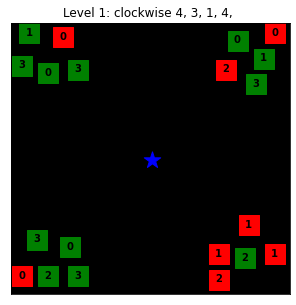

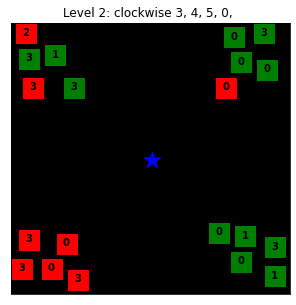

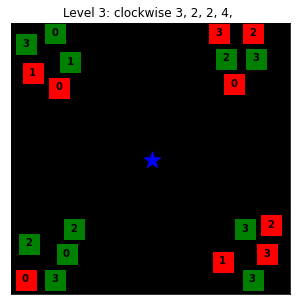

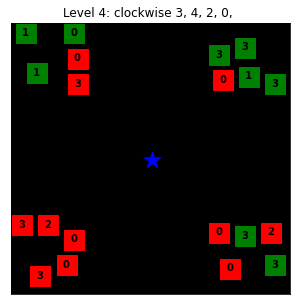

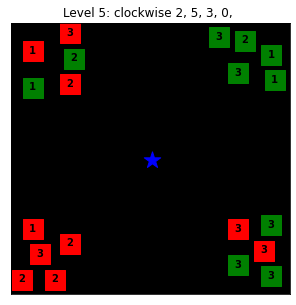

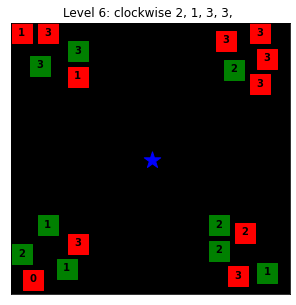

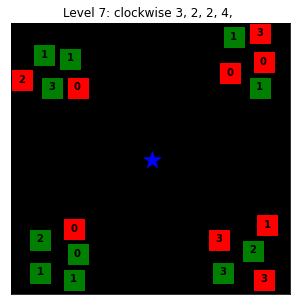

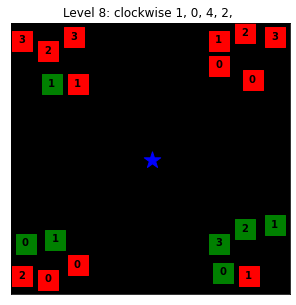

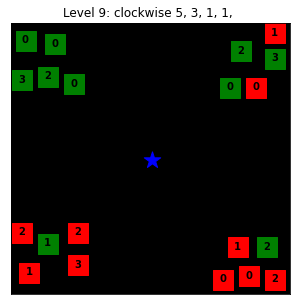

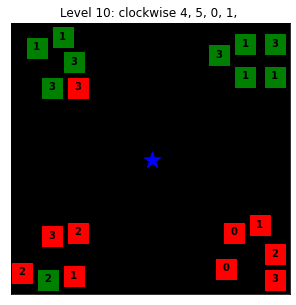

In [25]:
# Generate new levels
levels = [generate_random_level() for i in range(0,10)]
# actual_levels = generate_levels(actual_gameplay_config, levels)

actual_levels = existing_levels

for i,l in enumerate(actual_levels):
    
    value_str = ""
    for c in l["game_metadata"]["cluster_configs"]:
        value_str += "{}, ".format(c["actual_positive_value"])
    
    plot_control(l["frame_data"]["objects"], title="Level {}: clockwise {}".format(i+1, value_str), plot_x=5, plot_y=5)
    

In [26]:
json.dumps(actual_levels)
# pp.pprint(actual_levels)

'[{"frame_data": {"ms_elapsed": 0, "objects": [{"cluster_id": 1, "mask_value": 1, "value": 1, "x": 5, "y": 3}, {"cluster_id": 1, "mask_value": 0, "value": 1, "x": 10, "y": 14}, {"cluster_id": 1, "mask_value": 3, "value": 1, "x": 18, "y": 13}, {"cluster_id": 1, "mask_value": 3, "value": 1, "x": 3, "y": 12}, {"cluster_id": 1, "mask_value": 0, "value": -1, "x": 14, "y": 4}, {"cluster_id": 2, "mask_value": 1, "value": 1, "x": 68, "y": 10}, {"cluster_id": 2, "mask_value": 0, "value": 1, "x": 61, "y": 5}, {"cluster_id": 2, "mask_value": 3, "value": 1, "x": 66, "y": 17}, {"cluster_id": 2, "mask_value": 2, "value": -1, "x": 58, "y": 13}, {"cluster_id": 2, "mask_value": 0, "value": -1, "x": 71, "y": 3}, {"cluster_id": 3, "mask_value": 2, "value": 1, "x": 63, "y": 65}, {"cluster_id": 3, "mask_value": 1, "value": -1, "x": 71, "y": 64}, {"cluster_id": 3, "mask_value": 2, "value": -1, "x": 56, "y": 71}, {"cluster_id": 3, "mask_value": 1, "value": -1, "x": 64, "y": 56}, {"cluster_id": 3, "mask_value

In [27]:
values = []
for i, l in enumerate(actual_levels):
    objects = l["frame_data"]["objects"]
    net_value = sum([o["value"] for o in objects])
    values.append(net_value)
    print("Level {}: {} objects, {} net.".format(i+1, len(objects), net_value))

Level 1: 20 objects, 4 net.
Level 2: 20 objects, 4 net.
Level 3: 20 objects, 2 net.
Level 4: 20 objects, -2 net.
Level 5: 20 objects, 0 net.
Level 6: 20 objects, -2 net.
Level 7: 20 objects, 2 net.
Level 8: 20 objects, -6 net.
Level 9: 20 objects, 0 net.
Level 10: 20 objects, 0 net.


(array([1., 0., 0., 0., 2., 0., 3., 0., 2., 2.]),
 array([-6., -5., -4., -3., -2., -1.,  0.,  1.,  2.,  3.,  4.]),
 <BarContainer object of 10 artists>)

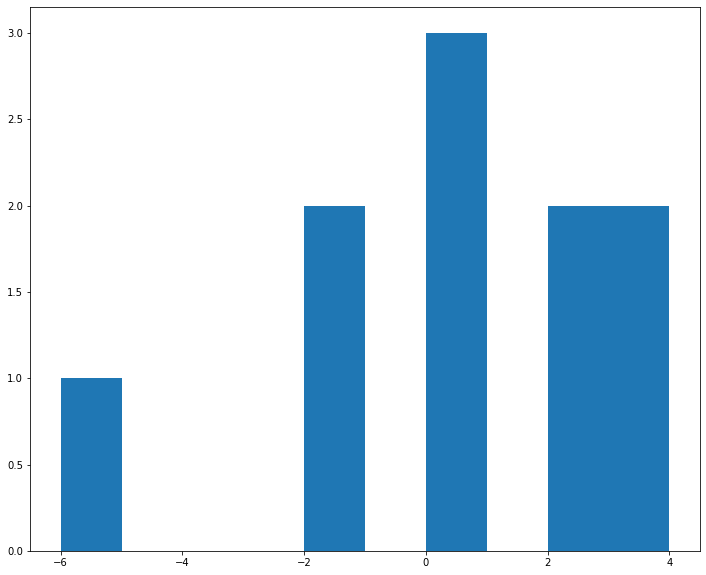

In [28]:
plt.hist(values)

In [29]:
actual_levels = [ { 'frame_data': { 'ms_elapsed': 0,
                    'objects': [ { 'cluster_id': 1,
                                   'mask_value': 2,
                                   'value': 1,
                                   'x': 7,
                                   'y': 9},
                                 { 'cluster_id': 1,
                                   'mask_value': 1,
                                   'value': 1,
                                   'x': 11,
                                   'y': 17},
                                 { 'cluster_id': 1,
                                   'mask_value': 2,
                                   'value': -1,
                                   'x': 16,
                                   'y': 6},
                                 { 'cluster_id': 1,
                                   'mask_value': 0,
                                   'value': -1,
                                   'x': 18,
                                   'y': 14},
                                 { 'cluster_id': 1,
                                   'mask_value': 1,
                                   'value': -1,
                                   'x': 4,
                                   'y': 17},
                                 { 'cluster_id': 2,
                                   'mask_value': 2,
                                   'value': 1,
                                   'x': 56,
                                   'y': 16},
                                 { 'cluster_id': 2,
                                   'mask_value': 3,
                                   'value': 1,
                                   'x': 70,
                                   'y': 16},
                                 { 'cluster_id': 2,
                                   'mask_value': 2,
                                   'value': -1,
                                   'x': 59,
                                   'y': 6},
                                 { 'cluster_id': 2,
                                   'mask_value': 0,
                                   'value': -1,
                                   'x': 69,
                                   'y': 5},
                                 { 'cluster_id': 2,
                                   'mask_value': 3,
                                   'value': -1,
                                   'x': 63,
                                   'y': 16},
                                 { 'cluster_id': 3,
                                   'mask_value': 0,
                                   'value': 1,
                                   'x': 69,
                                   'y': 71},
                                 { 'cluster_id': 3,
                                   'mask_value': 3,
                                   'value': 1,
                                   'x': 62,
                                   'y': 63},
                                 { 'cluster_id': 3,
                                   'mask_value': 0,
                                   'value': 1,
                                   'x': 62,
                                   'y': 71},
                                 { 'cluster_id': 3,
                                   'mask_value': 3,
                                   'value': 1,
                                   'x': 69,
                                   'y': 60},
                                 { 'cluster_id': 3,
                                   'mask_value': 2,
                                   'value': 1,
                                   'x': 61,
                                   'y': 56},
                                 { 'cluster_id': 4,
                                   'mask_value': 3,
                                   'value': 1,
                                   'x': 7,
                                   'y': 56},
                                 { 'cluster_id': 4,
                                   'mask_value': 0,
                                   'value': 1,
                                   'x': 11,
                                   'y': 70},
                                 { 'cluster_id': 4,
                                   'mask_value': 3,
                                   'value': 1,
                                   'x': 18,
                                   'y': 68},
                                 { 'cluster_id': 4,
                                   'mask_value': 3,
                                   'value': -1,
                                   'x': 3,
                                   'y': 68},
                                 { 'cluster_id': 4,
                                   'mask_value': 2,
                                   'value': -1,
                                   'x': 14,
                                   'y': 56}],
                    'player': {'x': 38, 'y': 38},
                    'score': 0},
    'game_metadata': { 'cluster_configs': [ { 'actual_negative_value': -3,
                                              'actual_positive_value': 2,
                                              'centroid': (11, 11),
                                              'id': 1,
                                              'num_objects': 5,
                                              'pos_objects': 2},
                                            { 'actual_negative_value': -3,
                                              'actual_positive_value': 2,
                                              'centroid': (64, 11),
                                              'id': 2,
                                              'num_objects': 5,
                                              'pos_objects': 2},
                                            { 'actual_negative_value': 0,
                                              'actual_positive_value': 5,
                                              'centroid': (64, 64),
                                              'id': 3,
                                              'num_objects': 5,
                                              'pos_objects': 5},
                                            { 'actual_negative_value': -2,
                                              'actual_positive_value': 3,
                                              'centroid': (11, 64),
                                              'id': 4,
                                              'num_objects': 5,
                                              'pos_objects': 3}],
                       'cluster_width': 20,
                       'grid_size': 75,
                       'level_duration_seconds': 8,
                       'level_number': 1,
                       'max_cluster_value': 5,
                       'name': 'boolean_1.0',
                       'object_padding': 7,
                       'object_size': 3,
                       'player_size': 5,
                       'uuid': '459e0701-5292-43ec-a7bf-e207365a8505'}},
  { 'frame_data': { 'ms_elapsed': 0,
                    'objects': [ { 'cluster_id': 1,
                                   'mask_value': 1,
                                   'value': -1,
                                   'x': 15,
                                   'y': 17},
                                 { 'cluster_id': 1,
                                   'mask_value': 2,
                                   'value': -1,
                                   'x': 9,
                                   'y': 4},
                                 { 'cluster_id': 1,
                                   'mask_value': 2,
                                   'value': -1,
                                   'x': 8,
                                   'y': 11},
                                 { 'cluster_id': 1,
                                   'mask_value': 0,
                                   'value': -1,
                                   'x': 3,
                                   'y': 18},
                                 { 'cluster_id': 1,
                                   'mask_value': 0,
                                   'value': -1,
                                   'x': 16,
                                   'y': 7},
                                 { 'cluster_id': 2,
                                   'mask_value': 3,
                                   'value': 1,
                                   'x': 57,
                                   'y': 14},
                                 { 'cluster_id': 2,
                                   'mask_value': 1,
                                   'value': -1,
                                   'x': 71,
                                   'y': 16},
                                 { 'cluster_id': 2,
                                   'mask_value': 3,
                                   'value': -1,
                                   'x': 61,
                                   'y': 5},
                                 { 'cluster_id': 2,
                                   'mask_value': 1,
                                   'value': -1,
                                   'x': 69,
                                   'y': 4},
                                 { 'cluster_id': 2,
                                   'mask_value': 3,
                                   'value': -1,
                                   'x': 64,
                                   'y': 14},
                                 { 'cluster_id': 3,
                                   'mask_value': 1,
                                   'value': 1,
                                   'x': 60,
                                   'y': 69},
                                 { 'cluster_id': 3,
                                   'mask_value': 2,
                                   'value': 1,
                                   'x': 56,
                                   'y': 60},
                                 { 'cluster_id': 3,
                                   'mask_value': 1,
                                   'value': -1,
                                   'x': 71,
                                   'y': 60},
                                 { 'cluster_id': 3,
                                   'mask_value': 0,
                                   'value': -1,
                                   'x': 71,
                                   'y': 68},
                                 { 'cluster_id': 3,
                                   'mask_value': 0,
                                   'value': -1,
                                   'x': 63,
                                   'y': 60},
                                 { 'cluster_id': 4,
                                   'mask_value': 1,
                                   'value': 1,
                                   'x': 15,
                                   'y': 68},
                                 { 'cluster_id': 4,
                                   'mask_value': 3,
                                   'value': -1,
                                   'x': 18,
                                   'y': 60},
                                 { 'cluster_id': 4,
                                   'mask_value': 3,
                                   'value': -1,
                                   'x': 4,
                                   'y': 68},
                                 { 'cluster_id': 4,
                                   'mask_value': 3,
                                   'value': -1,
                                   'x': 4,
                                   'y': 60},
                                 { 'cluster_id': 4,
                                   'mask_value': 3,
                                   'value': -1,
                                   'x': 11,
                                   'y': 57}],
                    'player': {'x': 38, 'y': 38},
                    'score': 0},
    'game_metadata': { 'cluster_configs': [ { 'actual_negative_value': -5,
                                              'actual_positive_value': 0,
                                              'centroid': (11, 11),
                                              'id': 1,
                                              'num_objects': 5,
                                              'pos_objects': 0},
                                            { 'actual_negative_value': -4,
                                              'actual_positive_value': 1,
                                              'centroid': (64, 11),
                                              'id': 2,
                                              'num_objects': 5,
                                              'pos_objects': 1},
                                            { 'actual_negative_value': -3,
                                              'actual_positive_value': 2,
                                              'centroid': (64, 64),
                                              'id': 3,
                                              'num_objects': 5,
                                              'pos_objects': 2},
                                            { 'actual_negative_value': -4,
                                              'actual_positive_value': 1,
                                              'centroid': (11, 64),
                                              'id': 4,
                                              'num_objects': 5,
                                              'pos_objects': 1}],
                       'cluster_width': 20,
                       'grid_size': 75,
                       'level_duration_seconds': 8,
                       'level_number': 2,
                       'max_cluster_value': 2,
                       'name': 'boolean_1.0',
                       'object_padding': 7,
                       'object_size': 3,
                       'player_size': 5,
                       'uuid': 'eaa23820-f9ff-4b42-af5f-78e54871f99f'}},
  { 'frame_data': { 'ms_elapsed': 0,
                    'objects': [ { 'cluster_id': 1,
                                   'mask_value': 1,
                                   'value': 1,
                                   'x': 12,
                                   'y': 13},
                                 { 'cluster_id': 1,
                                   'mask_value': 1,
                                   'value': 1,
                                   'x': 5,
                                   'y': 14},
                                 { 'cluster_id': 1,
                                   'mask_value': 3,
                                   'value': 1,
                                   'x': 10,
                                   'y': 3},
                                 { 'cluster_id': 1,
                                   'mask_value': 2,
                                   'value': 1,
                                   'x': 17,
                                   'y': 5},
                                 { 'cluster_id': 1,
                                   'mask_value': 2,
                                   'value': -1,
                                   'x': 3,
                                   'y': 6},
                                 { 'cluster_id': 2,
                                   'mask_value': 0,
                                   'value': 1,
                                   'x': 61,
                                   'y': 3},
                                 { 'cluster_id': 2,
                                   'mask_value': 1,
                                   'value': 1,
                                   'x': 61,
                                   'y': 17},
                                 { 'cluster_id': 2,
                                   'mask_value': 0,
                                   'value': 1,
                                   'x': 71,
                                   'y': 17},
                                 { 'cluster_id': 2,
                                   'mask_value': 2,
                                   'value': 1,
                                   'x': 68,
                                   'y': 8},
                                 { 'cluster_id': 2,
                                   'mask_value': 2,
                                   'value': -1,
                                   'x': 60,
                                   'y': 10},
                                 { 'cluster_id': 3,
                                   'mask_value': 3,
                                   'value': 1,
                                   'x': 70,
                                   'y': 63},
                                 { 'cluster_id': 3,
                                   'mask_value': 0,
                                   'value': 1,
                                   'x': 62,
                                   'y': 60},
                                 { 'cluster_id': 3,
                                   'mask_value': 0,
                                   'value': 1,
                                   'x': 63,
                                   'y': 68},
                                 { 'cluster_id': 3,
                                   'mask_value': 3,
                                   'value': 1,
                                   'x': 70,
                                   'y': 56},
                                 { 'cluster_id': 3,
                                   'mask_value': 0,
                                   'value': 1,
                                   'x': 56,
                                   'y': 68},
                                 { 'cluster_id': 4,
                                   'mask_value': 3,
                                   'value': 1,
                                   'x': 11,
                                   'y': 59},
                                 { 'cluster_id': 4,
                                   'mask_value': 0,
                                   'value': 1,
                                   'x': 12,
                                   'y': 67},
                                 { 'cluster_id': 4,
                                   'mask_value': 3,
                                   'value': 1,
                                   'x': 3,
                                   'y': 66},
                                 { 'cluster_id': 4,
                                   'mask_value': 0,
                                   'value': 1,
                                   'x': 4,
                                   'y': 57},
                                 { 'cluster_id': 4,
                                   'mask_value': 0,
                                   'value': -1,
                                   'x': 18,
                                   'y': 58}],
                    'player': {'x': 38, 'y': 38},
                    'score': 0},
    'game_metadata': { 'cluster_configs': [ { 'actual_negative_value': -1,
                                              'actual_positive_value': 4,
                                              'centroid': (11, 11),
                                              'id': 1,
                                              'num_objects': 5,
                                              'pos_objects': 4},
                                            { 'actual_negative_value': -1,
                                              'actual_positive_value': 4,
                                              'centroid': (64, 11),
                                              'id': 2,
                                              'num_objects': 5,
                                              'pos_objects': 4},
                                            { 'actual_negative_value': 0,
                                              'actual_positive_value': 5,
                                              'centroid': (64, 64),
                                              'id': 3,
                                              'num_objects': 5,
                                              'pos_objects': 5},
                                            { 'actual_negative_value': -1,
                                              'actual_positive_value': 4,
                                              'centroid': (11, 64),
                                              'id': 4,
                                              'num_objects': 5,
                                              'pos_objects': 4}],
                       'cluster_width': 20,
                       'grid_size': 75,
                       'level_duration_seconds': 8,
                       'level_number': 3,
                       'max_cluster_value': 5,
                       'name': 'boolean_1.0',
                       'object_padding': 7,
                       'object_size': 3,
                       'player_size': 5,
                       'uuid': 'fec41ef8-eb6f-4fdf-afa7-fba02c244ae1'}},
  { 'frame_data': { 'ms_elapsed': 0,
                    'objects': [ { 'cluster_id': 1,
                                   'mask_value': 2,
                                   'value': 1,
                                   'x': 18,
                                   'y': 15},
                                 { 'cluster_id': 1,
                                   'mask_value': 1,
                                   'value': 1,
                                   'x': 17,
                                   'y': 6},
                                 { 'cluster_id': 1,
                                   'mask_value': 2,
                                   'value': -1,
                                   'x': 10,
                                   'y': 13},
                                 { 'cluster_id': 1,
                                   'mask_value': 3,
                                   'value': -1,
                                   'x': 5,
                                   'y': 5},
                                 { 'cluster_id': 1,
                                   'mask_value': 0,
                                   'value': -1,
                                   'x': 3,
                                   'y': 15},
                                 { 'cluster_id': 2,
                                   'mask_value': 0,
                                   'value': -1,
                                   'x': 58,
                                   'y': 17},
                                 { 'cluster_id': 2,
                                   'mask_value': 3,
                                   'value': -1,
                                   'x': 66,
                                   'y': 17},
                                 { 'cluster_id': 2,
                                   'mask_value': 0,
                                   'value': -1,
                                   'x': 66,
                                   'y': 3},
                                 { 'cluster_id': 2,
                                   'mask_value': 2,
                                   'value': -1,
                                   'x': 57,
                                   'y': 3},
                                 { 'cluster_id': 2,
                                   'mask_value': 1,
                                   'value': -1,
                                   'x': 64,
                                   'y': 10},
                                 { 'cluster_id': 3,
                                   'mask_value': 2,
                                   'value': 1,
                                   'x': 64,
                                   'y': 59},
                                 { 'cluster_id': 3,
                                   'mask_value': 3,
                                   'value': -1,
                                   'x': 71,
                                   'y': 62},
                                 { 'cluster_id': 3,
                                   'mask_value': 3,
                                   'value': -1,
                                   'x': 56,
                                   'y': 67},
                                 { 'cluster_id': 3,
                                   'mask_value': 0,
                                   'value': -1,
                                   'x': 64,
                                   'y': 69},
                                 { 'cluster_id': 3,
                                   'mask_value': 3,
                                   'value': -1,
                                   'x': 57,
                                   'y': 57},
                                 { 'cluster_id': 4,
                                   'mask_value': 1,
                                   'value': 1,
                                   'x': 3,
                                   'y': 60},
                                 { 'cluster_id': 4,
                                   'mask_value': 3,
                                   'value': 1,
                                   'x': 3,
                                   'y': 70},
                                 { 'cluster_id': 4,
                                   'mask_value': 0,
                                   'value': 1,
                                   'x': 15,
                                   'y': 57},
                                 { 'cluster_id': 4,
                                   'mask_value': 0,
                                   'value': 1,
                                   'x': 12,
                                   'y': 71},
                                 { 'cluster_id': 4,
                                   'mask_value': 0,
                                   'value': 1,
                                   'x': 18,
                                   'y': 64}],
                    'player': {'x': 38, 'y': 38},
                    'score': 0},
    'game_metadata': { 'cluster_configs': [ { 'actual_negative_value': -3,
                                              'actual_positive_value': 2,
                                              'centroid': (11, 11),
                                              'id': 1,
                                              'num_objects': 5,
                                              'pos_objects': 2},
                                            { 'actual_negative_value': -5,
                                              'actual_positive_value': 0,
                                              'centroid': (64, 11),
                                              'id': 2,
                                              'num_objects': 5,
                                              'pos_objects': 0},
                                            { 'actual_negative_value': -4,
                                              'actual_positive_value': 1,
                                              'centroid': (64, 64),
                                              'id': 3,
                                              'num_objects': 5,
                                              'pos_objects': 1},
                                            { 'actual_negative_value': 0,
                                              'actual_positive_value': 5,
                                              'centroid': (11, 64),
                                              'id': 4,
                                              'num_objects': 5,
                                              'pos_objects': 5}],
                       'cluster_width': 20,
                       'grid_size': 75,
                       'level_duration_seconds': 8,
                       'level_number': 4,
                       'max_cluster_value': 5,
                       'name': 'boolean_1.0',
                       'object_padding': 7,
                       'object_size': 3,
                       'player_size': 5,
                       'uuid': 'ef5b3293-559d-4238-9439-16a8e4c7c63b'}},
  { 'frame_data': { 'ms_elapsed': 0,
                    'objects': [ { 'cluster_id': 1,
                                   'mask_value': 2,
                                   'value': -1,
                                   'x': 11,
                                   'y': 11},
                                 { 'cluster_id': 1,
                                   'mask_value': 3,
                                   'value': -1,
                                   'x': 4,
                                   'y': 5},
                                 { 'cluster_id': 1,
                                   'mask_value': 3,
                                   'value': -1,
                                   'x': 10,
                                   'y': 18},
                                 { 'cluster_id': 1,
                                   'mask_value': 2,
                                   'value': -1,
                                   'x': 18,
                                   'y': 8},
                                 { 'cluster_id': 1,
                                   'mask_value': 1,
                                   'value': -1,
                                   'x': 18,
                                   'y': 15},
                                 { 'cluster_id': 2,
                                   'mask_value': 2,
                                   'value': 1,
                                   'x': 63,
                                   'y': 3},
                                 { 'cluster_id': 2,
                                   'mask_value': 0,
                                   'value': -1,
                                   'x': 70,
                                   'y': 3},
                                 { 'cluster_id': 2,
                                   'mask_value': 2,
                                   'value': -1,
                                   'x': 68,
                                   'y': 12},
                                 { 'cluster_id': 2,
                                   'mask_value': 0,
                                   'value': -1,
                                   'x': 58,
                                   'y': 13},
                                 { 'cluster_id': 2,
                                   'mask_value': 2,
                                   'value': -1,
                                   'x': 56,
                                   'y': 4},
                                 { 'cluster_id': 3,
                                   'mask_value': 1,
                                   'value': -1,
                                   'x': 64,
                                   'y': 71},
                                 { 'cluster_id': 3,
                                   'mask_value': 1,
                                   'value': -1,
                                   'x': 62,
                                   'y': 62},
                                 { 'cluster_id': 3,
                                   'mask_value': 2,
                                   'value': -1,
                                   'x': 70,
                                   'y': 59},
                                 { 'cluster_id': 3,
                                   'mask_value': 1,
                                   'value': -1,
                                   'x': 71,
                                   'y': 70},
                                 { 'cluster_id': 3,
                                   'mask_value': 0,
                                   'value': -1,
                                   'x': 57,
                                   'y': 71},
                                 { 'cluster_id': 4,
                                   'mask_value': 1,
                                   'value': -1,
                                   'x': 13,
                                   'y': 60},
                                 { 'cluster_id': 4,
                                   'mask_value': 3,
                                   'value': -1,
                                   'x': 10,
                                   'y': 70},
                                 { 'cluster_id': 4,
                                   'mask_value': 0,
                                   'value': -1,
                                   'x': 3,
                                   'y': 70},
                                 { 'cluster_id': 4,
                                   'mask_value': 0,
                                   'value': -1,
                                   'x': 3,
                                   'y': 59},
                                 { 'cluster_id': 4,
                                   'mask_value': 2,
                                   'value': -1,
                                   'x': 17,
                                   'y': 71}],
                    'player': {'x': 38, 'y': 38},
                    'score': 0},
    'game_metadata': { 'cluster_configs': [ { 'actual_negative_value': -5,
                                              'actual_positive_value': 0,
                                              'centroid': (11, 11),
                                              'id': 1,
                                              'num_objects': 5,
                                              'pos_objects': 0},
                                            { 'actual_negative_value': -4,
                                              'actual_positive_value': 1,
                                              'centroid': (64, 11),
                                              'id': 2,
                                              'num_objects': 5,
                                              'pos_objects': 1},
                                            { 'actual_negative_value': -5,
                                              'actual_positive_value': 0,
                                              'centroid': (64, 64),
                                              'id': 3,
                                              'num_objects': 5,
                                              'pos_objects': 0},
                                            { 'actual_negative_value': -5,
                                              'actual_positive_value': 0,
                                              'centroid': (11, 64),
                                              'id': 4,
                                              'num_objects': 5,
                                              'pos_objects': 0}],
                       'cluster_width': 20,
                       'grid_size': 75,
                       'level_duration_seconds': 8,
                       'level_number': 5,
                       'max_cluster_value': 1,
                       'name': 'boolean_1.0',
                       'object_padding': 7,
                       'object_size': 3,
                       'player_size': 5,
                       'uuid': '9e7452a3-aafd-4986-934e-d1d5cc390a52'}},
  { 'frame_data': { 'ms_elapsed': 0,
                    'objects': [ { 'cluster_id': 1,
                                   'mask_value': 1,
                                   'value': 1,
                                   'x': 15,
                                   'y': 12},
                                 { 'cluster_id': 1,
                                   'mask_value': 2,
                                   'value': 1,
                                   'x': 18,
                                   'y': 5},
                                 { 'cluster_id': 1,
                                   'mask_value': 3,
                                   'value': 1,
                                   'x': 3,
                                   'y': 4},
                                 { 'cluster_id': 1,
                                   'mask_value': 3,
                                   'value': -1,
                                   'x': 4,
                                   'y': 14},
                                 { 'cluster_id': 1,
                                   'mask_value': 2,
                                   'value': -1,
                                   'x': 10,
                                   'y': 4},
                                 { 'cluster_id': 2,
                                   'mask_value': 2,
                                   'value': 1,
                                   'x': 63,
                                   'y': 8},
                                 { 'cluster_id': 2,
                                   'mask_value': 1,
                                   'value': 1,
                                   'x': 68,
                                   'y': 18},
                                 { 'cluster_id': 2,
                                   'mask_value': 3,
                                   'value': 1,
                                   'x': 56,
                                   'y': 4},
                                 { 'cluster_id': 2,
                                   'mask_value': 3,
                                   'value': 1,
                                   'x': 57,
                                   'y': 15},
                                 { 'cluster_id': 2,
                                   'mask_value': 0,
                                   'value': -1,
                                   'x': 71,
                                   'y': 10},
                                 { 'cluster_id': 3,
                                   'mask_value': 0,
                                   'value': 1,
                                   'x': 67,
                                   'y': 61},
                                 { 'cluster_id': 3,
                                   'mask_value': 1,
                                   'value': 1,
                                   'x': 59,
                                   'y': 63},
                                 { 'cluster_id': 3,
                                   'mask_value': 0,
                                   'value': 1,
                                   'x': 64,
                                   'y': 71},
                                 { 'cluster_id': 3,
                                   'mask_value': 2,
                                   'value': -1,
                                   'x': 60,
                                   'y': 56},
                                 { 'cluster_id': 3,
                                   'mask_value': 3,
                                   'value': -1,
                                   'x': 71,
                                   'y': 69},
                                 { 'cluster_id': 4,
                                   'mask_value': 2,
                                   'value': 1,
                                   'x': 7,
                                   'y': 59},
                                 { 'cluster_id': 4,
                                   'mask_value': 3,
                                   'value': 1,
                                   'x': 18,
                                   'y': 71},
                                 { 'cluster_id': 4,
                                   'mask_value': 3,
                                   'value': 1,
                                   'x': 18,
                                   'y': 56},
                                 { 'cluster_id': 4,
                                   'mask_value': 3,
                                   'value': 1,
                                   'x': 5,
                                   'y': 67},
                                 { 'cluster_id': 4,
                                   'mask_value': 0,
                                   'value': -1,
                                   'x': 17,
                                   'y': 64}],
                    'player': {'x': 38, 'y': 38},
                    'score': 0},
    'game_metadata': { 'cluster_configs': [ { 'actual_negative_value': -2,
                                              'actual_positive_value': 3,
                                              'centroid': (11, 11),
                                              'id': 1,
                                              'num_objects': 5,
                                              'pos_objects': 3},
                                            { 'actual_negative_value': -1,
                                              'actual_positive_value': 4,
                                              'centroid': (64, 11),
                                              'id': 2,
                                              'num_objects': 5,
                                              'pos_objects': 4},
                                            { 'actual_negative_value': -2,
                                              'actual_positive_value': 3,
                                              'centroid': (64, 64),
                                              'id': 3,
                                              'num_objects': 5,
                                              'pos_objects': 3},
                                            { 'actual_negative_value': -1,
                                              'actual_positive_value': 4,
                                              'centroid': (11, 64),
                                              'id': 4,
                                              'num_objects': 5,
                                              'pos_objects': 4}],
                       'cluster_width': 20,
                       'grid_size': 75,
                       'level_duration_seconds': 8,
                       'level_number': 6,
                       'max_cluster_value': 4,
                       'name': 'boolean_1.0',
                       'object_padding': 7,
                       'object_size': 3,
                       'player_size': 5,
                       'uuid': '64d9a002-8d37-43c9-8228-7106c0a18784'}},
  { 'frame_data': { 'ms_elapsed': 0,
                    'objects': [ { 'cluster_id': 1,
                                   'mask_value': 2,
                                   'value': 1,
                                   'x': 10,
                                   'y': 13},
                                 { 'cluster_id': 1,
                                   'mask_value': 1,
                                   'value': 1,
                                   'x': 11,
                                   'y': 5},
                                 { 'cluster_id': 1,
                                   'mask_value': 2,
                                   'value': -1,
                                   'x': 3,
                                   'y': 14},
                                 { 'cluster_id': 1,
                                   'mask_value': 2,
                                   'value': -1,
                                   'x': 3,
                                   'y': 3},
                                 { 'cluster_id': 1,
                                   'mask_value': 0,
                                   'value': -1,
                                   'x': 18,
                                   'y': 13},
                                 { 'cluster_id': 2,
                                   'mask_value': 2,
                                   'value': 1,
                                   'x': 71,
                                   'y': 11},
                                 { 'cluster_id': 2,
                                   'mask_value': 2,
                                   'value': 1,
                                   'x': 61,
                                   'y': 15},
                                 { 'cluster_id': 2,
                                   'mask_value': 1,
                                   'value': -1,
                                   'x': 61,
                                   'y': 5},
                                 { 'cluster_id': 2,
                                   'mask_value': 2,
                                   'value': -1,
                                   'x': 70,
                                   'y': 18},
                                 { 'cluster_id': 2,
                                   'mask_value': 2,
                                   'value': -1,
                                   'x': 71,
                                   'y': 4},
                                 { 'cluster_id': 3,
                                   'mask_value': 2,
                                   'value': -1,
                                   'x': 68,
                                   'y': 56},
                                 { 'cluster_id': 3,
                                   'mask_value': 1,
                                   'value': -1,
                                   'x': 56,
                                   'y': 62},
                                 { 'cluster_id': 3,
                                   'mask_value': 0,
                                   'value': -1,
                                   'x': 66,
                                   'y': 63},
                                 { 'cluster_id': 3,
                                   'mask_value': 0,
                                   'value': -1,
                                   'x': 62,
                                   'y': 71},
                                 { 'cluster_id': 3,
                                   'mask_value': 3,
                                   'value': -1,
                                   'x': 70,
                                   'y': 70},
                                 { 'cluster_id': 4,
                                   'mask_value': 1,
                                   'value': 1,
                                   'x': 11,
                                   'y': 67},
                                 { 'cluster_id': 4,
                                   'mask_value': 3,
                                   'value': 1,
                                   'x': 6,
                                   'y': 56},
                                 { 'cluster_id': 4,
                                   'mask_value': 3,
                                   'value': 1,
                                   'x': 3,
                                   'y': 66},
                                 { 'cluster_id': 4,
                                   'mask_value': 1,
                                   'value': 1,
                                   'x': 15,
                                   'y': 60},
                                 { 'cluster_id': 4,
                                   'mask_value': 3,
                                   'value': -1,
                                   'x': 18,
                                   'y': 69}],
                    'player': {'x': 38, 'y': 38},
                    'score': 0},
    'game_metadata': { 'cluster_configs': [ { 'actual_negative_value': -3,
                                              'actual_positive_value': 2,
                                              'centroid': (11, 11),
                                              'id': 1,
                                              'num_objects': 5,
                                              'pos_objects': 2},
                                            { 'actual_negative_value': -3,
                                              'actual_positive_value': 2,
                                              'centroid': (64, 11),
                                              'id': 2,
                                              'num_objects': 5,
                                              'pos_objects': 2},
                                            { 'actual_negative_value': -5,
                                              'actual_positive_value': 0,
                                              'centroid': (64, 64),
                                              'id': 3,
                                              'num_objects': 5,
                                              'pos_objects': 0},
                                            { 'actual_negative_value': -1,
                                              'actual_positive_value': 4,
                                              'centroid': (11, 64),
                                              'id': 4,
                                              'num_objects': 5,
                                              'pos_objects': 4}],
                       'cluster_width': 20,
                       'grid_size': 75,
                       'level_duration_seconds': 8,
                       'level_number': 7,
                       'max_cluster_value': 4,
                       'name': 'boolean_1.0',
                       'object_padding': 7,
                       'object_size': 3,
                       'player_size': 5,
                       'uuid': '551c6799-9712-40e5-a090-94b82a552709'}},
  { 'frame_data': { 'ms_elapsed': 0,
                    'objects': [ { 'cluster_id': 1,
                                   'mask_value': 0,
                                   'value': 1,
                                   'x': 17,
                                   'y': 13},
                                 { 'cluster_id': 1,
                                   'mask_value': 3,
                                   'value': 1,
                                   'x': 10,
                                   'y': 10},
                                 { 'cluster_id': 1,
                                   'mask_value': 0,
                                   'value': 1,
                                   'x': 7,
                                   'y': 18},
                                 { 'cluster_id': 1,
                                   'mask_value': 0,
                                   'value': 1,
                                   'x': 11,
                                   'y': 3},
                                 { 'cluster_id': 1,
                                   'mask_value': 2,
                                   'value': 1,
                                   'x': 3,
                                   'y': 4},
                                 { 'cluster_id': 2,
                                   'mask_value': 0,
                                   'value': 1,
                                   'x': 70,
                                   'y': 16},
                                 { 'cluster_id': 2,
                                   'mask_value': 0,
                                   'value': -1,
                                   'x': 63,
                                   'y': 5},
                                 { 'cluster_id': 2,
                                   'mask_value': 0,
                                   'value': -1,
                                   'x': 70,
                                   'y': 9},
                                 { 'cluster_id': 2,
                                   'mask_value': 1,
                                   'value': -1,
                                   'x': 56,
                                   'y': 10},
                                 { 'cluster_id': 2,
                                   'mask_value': 1,
                                   'value': -1,
                                   'x': 56,
                                   'y': 3},
                                 { 'cluster_id': 3,
                                   'mask_value': 3,
                                   'value': 1,
                                   'x': 64,
                                   'y': 71},
                                 { 'cluster_id': 3,
                                   'mask_value': 2,
                                   'value': 1,
                                   'x': 56,
                                   'y': 62},
                                 { 'cluster_id': 3,
                                   'mask_value': 1,
                                   'value': -1,
                                   'x': 65,
                                   'y': 63},
                                 { 'cluster_id': 3,
                                   'mask_value': 2,
                                   'value': -1,
                                   'x': 57,
                                   'y': 70},
                                 { 'cluster_id': 3,
                                   'mask_value': 1,
                                   'value': -1,
                                   'x': 68,
                                   'y': 56},
                                 { 'cluster_id': 4,
                                   'mask_value': 3,
                                   'value': 1,
                                   'x': 13,
                                   'y': 62},
                                 { 'cluster_id': 4,
                                   'mask_value': 3,
                                   'value': -1,
                                   'x': 12,
                                   'y': 71},
                                 { 'cluster_id': 4,
                                   'mask_value': 1,
                                   'value': -1,
                                   'x': 6,
                                   'y': 64},
                                 { 'cluster_id': 4,
                                   'mask_value': 3,
                                   'value': -1,
                                   'x': 3,
                                   'y': 57},
                                 { 'cluster_id': 4,
                                   'mask_value': 3,
                                   'value': -1,
                                   'x': 3,
                                   'y': 71}],
                    'player': {'x': 38, 'y': 38},
                    'score': 0},
    'game_metadata': { 'cluster_configs': [ { 'actual_negative_value': 0,
                                              'actual_positive_value': 5,
                                              'centroid': (11, 11),
                                              'id': 1,
                                              'num_objects': 5,
                                              'pos_objects': 5},
                                            { 'actual_negative_value': -4,
                                              'actual_positive_value': 1,
                                              'centroid': (64, 11),
                                              'id': 2,
                                              'num_objects': 5,
                                              'pos_objects': 1},
                                            { 'actual_negative_value': -3,
                                              'actual_positive_value': 2,
                                              'centroid': (64, 64),
                                              'id': 3,
                                              'num_objects': 5,
                                              'pos_objects': 2},
                                            { 'actual_negative_value': -4,
                                              'actual_positive_value': 1,
                                              'centroid': (11, 64),
                                              'id': 4,
                                              'num_objects': 5,
                                              'pos_objects': 1}],
                       'cluster_width': 20,
                       'grid_size': 75,
                       'level_duration_seconds': 8,
                       'level_number': 8,
                       'max_cluster_value': 5,
                       'name': 'boolean_1.0',
                       'object_padding': 7,
                       'object_size': 3,
                       'player_size': 5,
                       'uuid': '089ad01f-ba99-4c24-a309-2c3a10e9f4f5'}},
  { 'frame_data': { 'ms_elapsed': 0,
                    'objects': [ { 'cluster_id': 1,
                                   'mask_value': 1,
                                   'value': 1,
                                   'x': 11,
                                   'y': 7},
                                 { 'cluster_id': 1,
                                   'mask_value': 2,
                                   'value': 1,
                                   'x': 6,
                                   'y': 17},
                                 { 'cluster_id': 1,
                                   'mask_value': 1,
                                   'value': -1,
                                   'x': 14,
                                   'y': 17},
                                 { 'cluster_id': 1,
                                   'mask_value': 3,
                                   'value': -1,
                                   'x': 3,
                                   'y': 6},
                                 { 'cluster_id': 1,
                                   'mask_value': 3,
                                   'value': -1,
                                   'x': 18,
                                   'y': 7},
                                 { 'cluster_id': 2,
                                   'mask_value': 1,
                                   'value': 1,
                                   'x': 59,
                                   'y': 17},
                                 { 'cluster_id': 2,
                                   'mask_value': 3,
                                   'value': 1,
                                   'x': 58,
                                   'y': 6},
                                 { 'cluster_id': 2,
                                   'mask_value': 1,
                                   'value': -1,
                                   'x': 69,
                                   'y': 18},
                                 { 'cluster_id': 2,
                                   'mask_value': 1,
                                   'value': -1,
                                   'x': 67,
                                   'y': 10},
                                 { 'cluster_id': 2,
                                   'mask_value': 1,
                                   'value': -1,
                                   'x': 65,
                                   'y': 3},
                                 { 'cluster_id': 3,
                                   'mask_value': 2,
                                   'value': 1,
                                   'x': 68,
                                   'y': 67},
                                 { 'cluster_id': 3,
                                   'mask_value': 0,
                                   'value': 1,
                                   'x': 65,
                                   'y': 60},
                                 { 'cluster_id': 3,
                                   'mask_value': 1,
                                   'value': 1,
                                   'x': 56,
                                   'y': 63},
                                 { 'cluster_id': 3,
                                   'mask_value': 0,
                                   'value': 1,
                                   'x': 57,
                                   'y': 70},
                                 { 'cluster_id': 3,
                                   'mask_value': 0,
                                   'value': 1,
                                   'x': 57,
                                   'y': 56},
                                 { 'cluster_id': 4,
                                   'mask_value': 1,
                                   'value': 1,
                                   'x': 12,
                                   'y': 63},
                                 { 'cluster_id': 4,
                                   'mask_value': 2,
                                   'value': 1,
                                   'x': 4,
                                   'y': 67},
                                 { 'cluster_id': 4,
                                   'mask_value': 1,
                                   'value': 1,
                                   'x': 15,
                                   'y': 56},
                                 { 'cluster_id': 4,
                                   'mask_value': 2,
                                   'value': -1,
                                   'x': 11,
                                   'y': 70},
                                 { 'cluster_id': 4,
                                   'mask_value': 3,
                                   'value': -1,
                                   'x': 5,
                                   'y': 57}],
                    'player': {'x': 38, 'y': 38},
                    'score': 0},
    'game_metadata': { 'cluster_configs': [ { 'actual_negative_value': -3,
                                              'actual_positive_value': 2,
                                              'centroid': (11, 11),
                                              'id': 1,
                                              'num_objects': 5,
                                              'pos_objects': 2},
                                            { 'actual_negative_value': -3,
                                              'actual_positive_value': 2,
                                              'centroid': (64, 11),
                                              'id': 2,
                                              'num_objects': 5,
                                              'pos_objects': 2},
                                            { 'actual_negative_value': 0,
                                              'actual_positive_value': 5,
                                              'centroid': (64, 64),
                                              'id': 3,
                                              'num_objects': 5,
                                              'pos_objects': 5},
                                            { 'actual_negative_value': -2,
                                              'actual_positive_value': 3,
                                              'centroid': (11, 64),
                                              'id': 4,
                                              'num_objects': 5,
                                              'pos_objects': 3}],
                       'cluster_width': 20,
                       'grid_size': 75,
                       'level_duration_seconds': 8,
                       'level_number': 9,
                       'max_cluster_value': 5,
                       'name': 'boolean_1.0',
                       'object_padding': 7,
                       'object_size': 3,
                       'player_size': 5,
                       'uuid': '9de9f4a2-d8d1-4879-9d8e-3dbd82130bef'}},
  { 'frame_data': { 'ms_elapsed': 0,
                    'objects': [ { 'cluster_id': 1,
                                   'mask_value': 1,
                                   'value': 1,
                                   'x': 13,
                                   'y': 14},
                                 { 'cluster_id': 1,
                                   'mask_value': 3,
                                   'value': 1,
                                   'x': 4,
                                   'y': 10},
                                 { 'cluster_id': 1,
                                   'mask_value': 1,
                                   'value': 1,
                                   'x': 14,
                                   'y': 5},
                                 { 'cluster_id': 1,
                                   'mask_value': 2,
                                   'value': 1,
                                   'x': 6,
                                   'y': 18},
                                 { 'cluster_id': 1,
                                   'mask_value': 3,
                                   'value': 1,
                                   'x': 5,
                                   'y': 3},
                                 { 'cluster_id': 2,
                                   'mask_value': 2,
                                   'value': 1,
                                   'x': 58,
                                   'y': 10},
                                 { 'cluster_id': 2,
                                   'mask_value': 3,
                                   'value': 1,
                                   'x': 68,
                                   'y': 4},
                                 { 'cluster_id': 2,
                                   'mask_value': 3,
                                   'value': 1,
                                   'x': 70,
                                   'y': 12},
                                 { 'cluster_id': 2,
                                   'mask_value': 1,
                                   'value': 1,
                                   'x': 60,
                                   'y': 18},
                                 { 'cluster_id': 2,
                                   'mask_value': 2,
                                   'value': 1,
                                   'x': 58,
                                   'y': 3},
                                 { 'cluster_id': 3,
                                   'mask_value': 2,
                                   'value': 1,
                                   'x': 69,
                                   'y': 69},
                                 { 'cluster_id': 3,
                                   'mask_value': 3,
                                   'value': 1,
                                   'x': 60,
                                   'y': 64},
                                 { 'cluster_id': 3,
                                   'mask_value': 1,
                                   'value': 1,
                                   'x': 63,
                                   'y': 56},
                                 { 'cluster_id': 3,
                                   'mask_value': 1,
                                   'value': 1,
                                   'x': 70,
                                   'y': 59},
                                 { 'cluster_id': 3,
                                   'mask_value': 1,
                                   'value': -1,
                                   'x': 56,
                                   'y': 56},
                                 { 'cluster_id': 4,
                                   'mask_value': 0,
                                   'value': 1,
                                   'x': 11,
                                   'y': 57},
                                 { 'cluster_id': 4,
                                   'mask_value': 1,
                                   'value': 1,
                                   'x': 18,
                                   'y': 71},
                                 { 'cluster_id': 4,
                                   'mask_value': 3,
                                   'value': 1,
                                   'x': 4,
                                   'y': 66},
                                 { 'cluster_id': 4,
                                   'mask_value': 2,
                                   'value': 1,
                                   'x': 11,
                                   'y': 65},
                                 { 'cluster_id': 4,
                                   'mask_value': 3,
                                   'value': 1,
                                   'x': 4,
                                   'y': 56}],
                    'player': {'x': 38, 'y': 38},
                    'score': 0},
    'game_metadata': { 'cluster_configs': [ { 'actual_negative_value': 0,
                                              'actual_positive_value': 5,
                                              'centroid': (11, 11),
                                              'id': 1,
                                              'num_objects': 5,
                                              'pos_objects': 5},
                                            { 'actual_negative_value': 0,
                                              'actual_positive_value': 5,
                                              'centroid': (64, 11),
                                              'id': 2,
                                              'num_objects': 5,
                                              'pos_objects': 5},
                                            { 'actual_negative_value': -1,
                                              'actual_positive_value': 4,
                                              'centroid': (64, 64),
                                              'id': 3,
                                              'num_objects': 5,
                                              'pos_objects': 4},
                                            { 'actual_negative_value': 0,
                                              'actual_positive_value': 5,
                                              'centroid': (11, 64),
                                              'id': 4,
                                              'num_objects': 5,
                                              'pos_objects': 5}],
                       'cluster_width': 20,
                       'grid_size': 75,
                       'level_duration_seconds': 8,
                       'level_number': 10,
                       'max_cluster_value': 5,
                       'name': 'boolean_1.0',
                       'object_padding': 7,
                       'object_size': 3,
                       'player_size': 5,
                       'uuid': 'b3f18056-c8c2-4f26-9068-82139ac43078'}}]

In [30]:
import matplotlib as mpl
import itertools

ALL_FEATURES = set(''.join(s) for s in itertools.product('01', repeat=3))

CLASS_ONE_FEATURES = {
    1: ["000", "001", "010", "011"],
    -1:["100", "101", "110", "111"]}

CLASS_TWO_FEATURES = {
    1: ["010", "011", "100", "101"],
    -1:["000", "001", "110", "111"]}

CLASS_THREE_FEATURES = {
    1: ["001", "010", "011", "110"],
    -1:["000", "100", "101", "111"]}

CLASS_FOUR_FEATURES = {
    1: ["001", "010", "011", "111"],
    -1:["000", "100", "101", "110"]}

CLASS_FIVE_FEATURES = {
    1: ["001", "010", "011", "100"],
    -1:["000", "101", "110", "111"]}

CLASS_SIX_FEATURES = {
    1: ["000", "011", "101", "110"],
    -1:["001", "010", "100", "111"]}

def get_viz_string(object_dict, class_features):
    
    pos_features = set(class_features[1])
    neg_features = set(class_features[-1])
    
    # no overlap
    assert(pos_features.isdisjoint(neg_features))
    # full coverage
    assert(set(pos_features.union(neg_features)) == ALL_FEATURES)
    
    return class_features[object_dict["value"]][object_dict["mask_value"]]

def update_object_with_mask(object_dict, class_features):
    
    string = get_viz_string(object_dict, class_features)
    
    color = 'm' if string[0] == '1' else 'c'
    shape = '^' if string[1] == '1' else 's'
    hollow = True if string[2] == '1' else False
    
    object_dict.update({"color": color, "shape": shape, "hollow": hollow})
    
    return object_dict


def plot_boolean_colors(original_object_list, class_features,
                        plot_x=5, plot_y=5, title="", label_values=False, ax=None):    

    if ax is None:
        ax = plt.figure(figsize=(plot_x, plot_y)).gca()
    
    object_list = copy.deepcopy(original_object_list)
    object_list = [update_object_with_mask(o, class_features) for o in object_list]
    
    objects_df = pd.DataFrame(object_list)
    

    ax.set_facecolor('k')
    ax.scatter(38, 38, s=300, marker='*', color='r')
        
    for s, df in objects_df.groupby("shape"):
        ax.scatter(df.x, df.y, s=400, 
                    marker=s,
                    color=df.color.values)
    
    for s, df in objects_df[objects_df.hollow == True].groupby("shape"):
        ax.scatter(df.x, df.y, s=200, 
            marker=s,
            color='k')
                
    ax.set_xlim(0, 75)
    ax.set_ylim(75,0)
    ax.set_xticks([])
    ax.set_yticks([])

#     plt.suptitle(title)

#     plt.show()

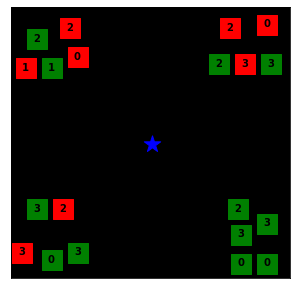

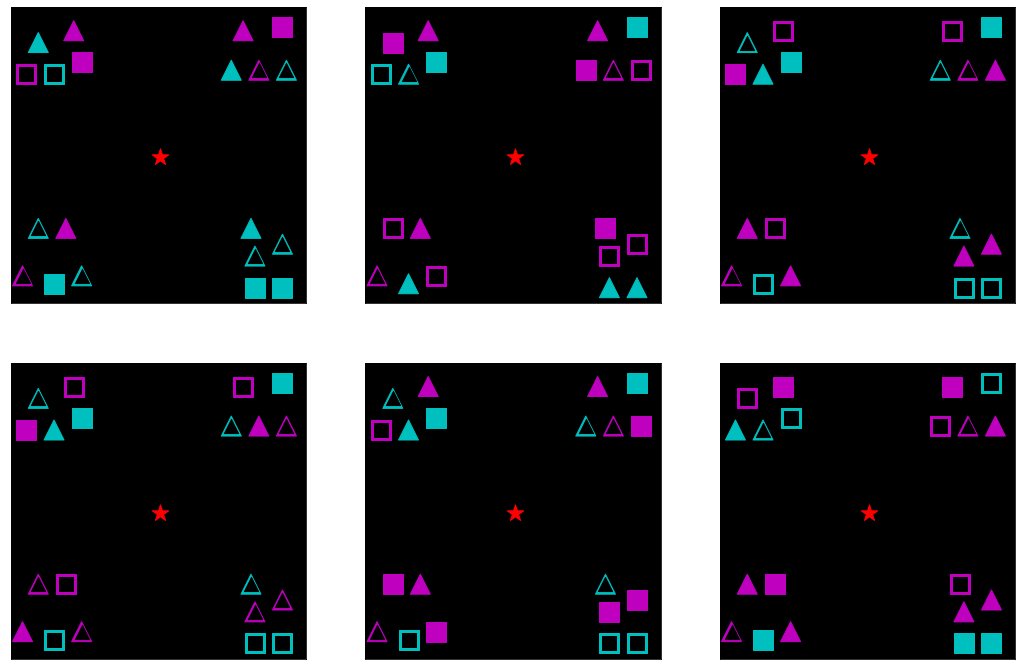

In [31]:
plot_control(actual_levels[0]['frame_data']['objects'])

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(18, 12))

features = [CLASS_ONE_FEATURES, CLASS_TWO_FEATURES, CLASS_THREE_FEATURES, CLASS_FOUR_FEATURES, CLASS_FIVE_FEATURES, CLASS_SIX_FEATURES]

for ax, feature in zip(axs.reshape(-1), features):
    plot_boolean_colors(actual_levels[0]['frame_data']['objects'], class_features=feature, ax=ax)

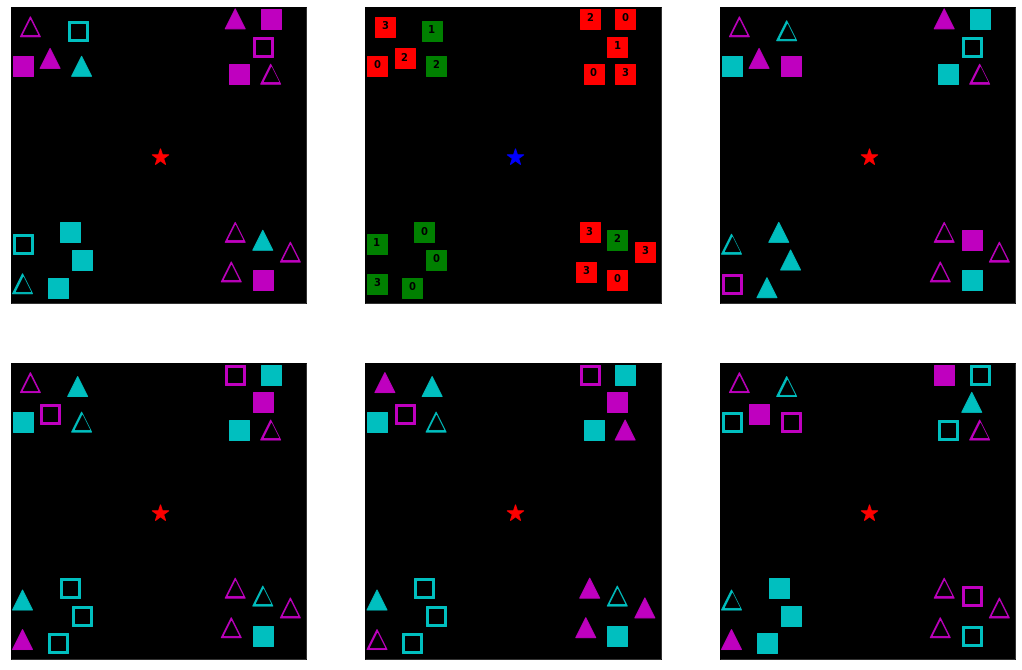

In [32]:
level = actual_levels[3]

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(18, 12))
axs = axs.reshape(-1)

plot_control(level['frame_data']['objects'], ax=axs[1])
plot_boolean_colors(level['frame_data']['objects'], ax=axs[0], class_features=CLASS_ONE_FEATURES)
plot_boolean_colors(level['frame_data']['objects'], ax=axs[2], class_features=CLASS_TWO_FEATURES)
plot_boolean_colors(level['frame_data']['objects'], ax=axs[3], class_features=CLASS_THREE_FEATURES)
plot_boolean_colors(level['frame_data']['objects'], ax=axs[4], class_features=CLASS_FOUR_FEATURES)
plot_boolean_colors(level['frame_data']['objects'], ax=axs[5], class_features=CLASS_SIX_FEATURES)


# Concept Display
Generate a set of objects to display across the top bar.

In [33]:
x_start = 14
gap = 13
y_val = -4
spacing = 6

data = [{"game_metadata": 
  {"name": "boolean_1.0", 
   "level_duration_seconds": 8, 
   "grid_size": 75, 
   "player_size": 5, 
   "object_size": 3, 
   "object_padding": 7, 
   "cluster_width": 20, 
   "uuid": "a25b8018-ff92-4adb-bc98-499516aca182", 
   "level_number": 1, 
   "max_cluster_value": 4, 
   "cluster_configs": [{"centroid": [11, 11], "num_objects": 5, "pos_objects": 4, "id": 1, "actual_positive_value": 4, "actual_negative_value": -1}, {"centroid": [64, 11], "num_objects": 5, "pos_objects": 4, "id": 2, "actual_positive_value": 4, "actual_negative_value": -1}, {"centroid": [64, 64], "num_objects": 5, "pos_objects": 0, "id": 3, "actual_positive_value": 0, "actual_negative_value": -5}, {"centroid": [11, 64], "num_objects": 5, "pos_objects": 0, "id": 4, "actual_positive_value": 0, "actual_negative_value": -5}]}, 
  "frame_data": 
      {"objects": 
       [{"x": x_start, "y": y_val, "value": 1, "mask_value": 0, "cluster_id": 1}, 
        {"x": x_start + spacing, "y": y_val, "value": 1, "mask_value": 1, "cluster_id": 1}, 
        {"x": x_start + 2*spacing, "y": y_val, "value": 1, "mask_value": 2, "cluster_id": 1}, 
        {"x": x_start + 3*spacing, "y": y_val, "value": 1, "mask_value": 3, "cluster_id": 1}, 
        
        {"x": x_start + gap + 4*spacing, "y": y_val, "value": -1, "mask_value": 0, "cluster_id": 2}, 
        {"x": x_start + gap + 5*spacing, "y": y_val, "value": -1, "mask_value": 1, "cluster_id": 2}, 
        {"x": x_start + gap + 6*spacing, "y": y_val, "value": -1, "mask_value": 2, "cluster_id": 2}, 
        {"x": x_start + gap + 7*spacing, "y": y_val, "value": -1, "mask_value": 3, "cluster_id": 2}], 
       "player": {"x": 38, "y": 38}, "score": 0, "ms_elapsed": 0}}]

In [34]:
json.dumps(data)

'[{"game_metadata": {"name": "boolean_1.0", "level_duration_seconds": 8, "grid_size": 75, "player_size": 5, "object_size": 3, "object_padding": 7, "cluster_width": 20, "uuid": "a25b8018-ff92-4adb-bc98-499516aca182", "level_number": 1, "max_cluster_value": 4, "cluster_configs": [{"centroid": [11, 11], "num_objects": 5, "pos_objects": 4, "id": 1, "actual_positive_value": 4, "actual_negative_value": -1}, {"centroid": [64, 11], "num_objects": 5, "pos_objects": 4, "id": 2, "actual_positive_value": 4, "actual_negative_value": -1}, {"centroid": [64, 64], "num_objects": 5, "pos_objects": 0, "id": 3, "actual_positive_value": 0, "actual_negative_value": -5}, {"centroid": [11, 64], "num_objects": 5, "pos_objects": 0, "id": 4, "actual_positive_value": 0, "actual_negative_value": -5}]}, "frame_data": {"objects": [{"x": 14, "y": -4, "value": 1, "mask_value": 0, "cluster_id": 1}, {"x": 20, "y": -4, "value": 1, "mask_value": 1, "cluster_id": 1}, {"x": 26, "y": -4, "value": 1, "mask_value": 2, "cluster

In [35]:
import pprint
pp = pprint.PrettyPrinter(indent=2, width=100)

In [36]:
import itertools

viz = ["full"]
comm = ["chat", "demo"]
# complexity = [x for x in range(1,7)]
complexity = [1, 2, 3, 6]

all_conds = list(itertools.product(viz, comm, complexity))

condition_dict = {}
for i, (v, comm, comp) in enumerate(all_conds):
    condition_dict[i] = {"visibility": v, "communication": comm, "concept_complexity": comp}

pp.pprint(condition_dict)


{ 0: {'communication': 'chat', 'concept_complexity': 1, 'visibility': 'full'},
  1: {'communication': 'chat', 'concept_complexity': 2, 'visibility': 'full'},
  2: {'communication': 'chat', 'concept_complexity': 3, 'visibility': 'full'},
  3: {'communication': 'chat', 'concept_complexity': 6, 'visibility': 'full'},
  4: {'communication': 'demo', 'concept_complexity': 1, 'visibility': 'full'},
  5: {'communication': 'demo', 'concept_complexity': 2, 'visibility': 'full'},
  6: {'communication': 'demo', 'concept_complexity': 3, 'visibility': 'full'},
  7: {'communication': 'demo', 'concept_complexity': 6, 'visibility': 'full'}}


# Author Response

Re-run Exp 2, but re-structure spatially into crosses.

In [74]:
original_gameplay_levels = [{"frame_data": {"ms_elapsed": 0, "objects": [{"cluster_id": 1, "mask_value": 1, "value": 1, "x": 5, "y": 3}, {"cluster_id": 1, "mask_value": 0, "value": 1, "x": 10, "y": 14}, {"cluster_id": 1, "mask_value": 3, "value": 1, "x": 18, "y": 13}, {"cluster_id": 1, "mask_value": 3, "value": 1, "x": 3, "y": 12}, {"cluster_id": 1, "mask_value": 0, "value": -1, "x": 14, "y": 4}, {"cluster_id": 2, "mask_value": 1, "value": 1, "x": 68, "y": 10}, {"cluster_id": 2, "mask_value": 0, "value": 1, "x": 61, "y": 5}, {"cluster_id": 2, "mask_value": 3, "value": 1, "x": 66, "y": 17}, {"cluster_id": 2, "mask_value": 2, "value": -1, "x": 58, "y": 13}, {"cluster_id": 2, "mask_value": 0, "value": -1, "x": 71, "y": 3}, {"cluster_id": 3, "mask_value": 2, "value": 1, "x": 63, "y": 65}, {"cluster_id": 3, "mask_value": 1, "value": -1, "x": 71, "y": 64}, {"cluster_id": 3, "mask_value": 2, "value": -1, "x": 56, "y": 71}, {"cluster_id": 3, "mask_value": 1, "value": -1, "x": 64, "y": 56}, {"cluster_id": 3, "mask_value": 1, "value": -1, "x": 56, "y": 64}, {"cluster_id": 4, "mask_value": 2, "value": 1, "x": 10, "y": 70}, {"cluster_id": 4, "mask_value": 3, "value": 1, "x": 7, "y": 60}, {"cluster_id": 4, "mask_value": 3, "value": 1, "x": 18, "y": 70}, {"cluster_id": 4, "mask_value": 0, "value": 1, "x": 16, "y": 62}, {"cluster_id": 4, "mask_value": 0, "value": -1, "x": 3, "y": 70}], "player": {"x": 38, "y": 38}, "score": 0}, "game_metadata": {"cluster_configs": [{"actual_negative_value": -1, "actual_positive_value": 4, "centroid": [11, 11], "id": 1, "num_objects": 5, "pos_objects": 4}, {"actual_negative_value": -2, "actual_positive_value": 3, "centroid": [64, 11], "id": 2, "num_objects": 5, "pos_objects": 3}, {"actual_negative_value": -4, "actual_positive_value": 1, "centroid": [64, 64], "id": 3, "num_objects": 5, "pos_objects": 1}, {"actual_negative_value": -1, "actual_positive_value": 4, "centroid": [11, 64], "id": 4, "num_objects": 5, "pos_objects": 4}], "cluster_width": 20, "grid_size": 75, "level_duration_seconds": 8, "level_number": 1, "max_cluster_value": 4, "name": "boolean_1.0", "object_padding": 7, "object_size": 3, "player_size": 5, "uuid": "a419773b-19e6-460d-848a-0ecf2ab477dc"}}, {"frame_data": {"ms_elapsed": 0, "objects": [{"cluster_id": 1, "mask_value": 3, "value": 1, "x": 17, "y": 18}, {"cluster_id": 1, "mask_value": 1, "value": 1, "x": 12, "y": 9}, {"cluster_id": 1, "mask_value": 3, "value": 1, "x": 5, "y": 10}, {"cluster_id": 1, "mask_value": 3, "value": -1, "x": 6, "y": 18}, {"cluster_id": 1, "mask_value": 2, "value": -1, "x": 4, "y": 3}, {"cluster_id": 2, "mask_value": 0, "value": 1, "x": 62, "y": 11}, {"cluster_id": 2, "mask_value": 0, "value": 1, "x": 60, "y": 4}, {"cluster_id": 2, "mask_value": 0, "value": 1, "x": 69, "y": 13}, {"cluster_id": 2, "mask_value": 3, "value": 1, "x": 68, "y": 3}, {"cluster_id": 2, "mask_value": 0, "value": -1, "x": 58, "y": 18}, {"cluster_id": 3, "mask_value": 0, "value": 1, "x": 62, "y": 66}, {"cluster_id": 3, "mask_value": 1, "value": 1, "x": 63, "y": 59}, {"cluster_id": 3, "mask_value": 3, "value": 1, "x": 71, "y": 62}, {"cluster_id": 3, "mask_value": 0, "value": 1, "x": 56, "y": 58}, {"cluster_id": 3, "mask_value": 1, "value": 1, "x": 71, "y": 70}, {"cluster_id": 4, "mask_value": 0, "value": -1, "x": 15, "y": 61}, {"cluster_id": 4, "mask_value": 3, "value": -1, "x": 5, "y": 60}, {"cluster_id": 4, "mask_value": 0, "value": -1, "x": 11, "y": 68}, {"cluster_id": 4, "mask_value": 3, "value": -1, "x": 18, "y": 71}, {"cluster_id": 4, "mask_value": 3, "value": -1, "x": 3, "y": 68}], "player": {"x": 38, "y": 38}, "score": 0}, "game_metadata": {"cluster_configs": [{"actual_negative_value": -2, "actual_positive_value": 3, "centroid": [11, 11], "id": 1, "num_objects": 5, "pos_objects": 3}, {"actual_negative_value": -1, "actual_positive_value": 4, "centroid": [64, 11], "id": 2, "num_objects": 5, "pos_objects": 4}, {"actual_negative_value": 0, "actual_positive_value": 5, "centroid": [64, 64], "id": 3, "num_objects": 5, "pos_objects": 5}, {"actual_negative_value": -5, "actual_positive_value": 0, "centroid": [11, 64], "id": 4, "num_objects": 5, "pos_objects": 0}], "cluster_width": 20, "grid_size": 75, "level_duration_seconds": 8, "level_number": 2, "max_cluster_value": 5, "name": "boolean_1.0", "object_padding": 7, "object_size": 3, "player_size": 5, "uuid": "16fa8542-d5ca-4189-a6f9-7effd8b3aa4d"}}, {"frame_data": {"ms_elapsed": 0, "objects": [{"cluster_id": 1, "mask_value": 3, "value": 1, "x": 4, "y": 6}, {"cluster_id": 1, "mask_value": 0, "value": 1, "x": 12, "y": 3}, {"cluster_id": 1, "mask_value": 1, "value": 1, "x": 16, "y": 11}, {"cluster_id": 1, "mask_value": 1, "value": -1, "x": 6, "y": 14}, {"cluster_id": 1, "mask_value": 0, "value": -1, "x": 13, "y": 18}, {"cluster_id": 2, "mask_value": 2, "value": 1, "x": 58, "y": 10}, {"cluster_id": 2, "mask_value": 3, "value": 1, "x": 66, "y": 10}, {"cluster_id": 2, "mask_value": 0, "value": -1, "x": 60, "y": 17}, {"cluster_id": 2, "mask_value": 2, "value": -1, "x": 65, "y": 3}, {"cluster_id": 2, "mask_value": 3, "value": -1, "x": 56, "y": 3}, {"cluster_id": 3, "mask_value": 3, "value": 1, "x": 63, "y": 57}, {"cluster_id": 3, "mask_value": 3, "value": 1, "x": 65, "y": 71}, {"cluster_id": 3, "mask_value": 1, "value": -1, "x": 57, "y": 66}, {"cluster_id": 3, "mask_value": 2, "value": -1, "x": 70, "y": 56}, {"cluster_id": 3, "mask_value": 3, "value": -1, "x": 69, "y": 64}, {"cluster_id": 4, "mask_value": 0, "value": 1, "x": 15, "y": 64}, {"cluster_id": 4, "mask_value": 3, "value": 1, "x": 12, "y": 71}, {"cluster_id": 4, "mask_value": 2, "value": 1, "x": 17, "y": 57}, {"cluster_id": 4, "mask_value": 2, "value": 1, "x": 5, "y": 61}, {"cluster_id": 4, "mask_value": 0, "value": -1, "x": 4, "y": 71}], "player": {"x": 38, "y": 38}, "score": 0}, "game_metadata": {"cluster_configs": [{"actual_negative_value": -2, "actual_positive_value": 3, "centroid": [11, 11], "id": 1, "num_objects": 5, "pos_objects": 3}, {"actual_negative_value": -3, "actual_positive_value": 2, "centroid": [64, 11], "id": 2, "num_objects": 5, "pos_objects": 2}, {"actual_negative_value": -3, "actual_positive_value": 2, "centroid": [64, 64], "id": 3, "num_objects": 5, "pos_objects": 2}, {"actual_negative_value": -1, "actual_positive_value": 4, "centroid": [11, 64], "id": 4, "num_objects": 5, "pos_objects": 4}], "cluster_width": 20, "grid_size": 75, "level_duration_seconds": 8, "level_number": 3, "max_cluster_value": 4, "name": "boolean_1.0", "object_padding": 7, "object_size": 3, "player_size": 5, "uuid": "ad10cd70-85ae-43fc-9ef5-dfc4d5546d2c"}}, {"frame_data": {"ms_elapsed": 0, "objects": [{"cluster_id": 1, "mask_value": 1, "value": 1, "x": 7, "y": 14}, {"cluster_id": 1, "mask_value": 1, "value": 1, "x": 4, "y": 3}, {"cluster_id": 1, "mask_value": 0, "value": 1, "x": 17, "y": 3}, {"cluster_id": 1, "mask_value": 3, "value": -1, "x": 18, "y": 17}, {"cluster_id": 1, "mask_value": 0, "value": -1, "x": 18, "y": 10}, {"cluster_id": 2, "mask_value": 1, "value": 1, "x": 64, "y": 15}, {"cluster_id": 2, "mask_value": 3, "value": 1, "x": 63, "y": 7}, {"cluster_id": 2, "mask_value": 3, "value": 1, "x": 56, "y": 9}, {"cluster_id": 2, "mask_value": 3, "value": 1, "x": 71, "y": 17}, {"cluster_id": 2, "mask_value": 0, "value": -1, "x": 57, "y": 16}, {"cluster_id": 3, "mask_value": 3, "value": 1, "x": 71, "y": 67}, {"cluster_id": 3, "mask_value": 3, "value": 1, "x": 63, "y": 59}, {"cluster_id": 3, "mask_value": 2, "value": -1, "x": 70, "y": 58}, {"cluster_id": 3, "mask_value": 0, "value": -1, "x": 59, "y": 68}, {"cluster_id": 3, "mask_value": 0, "value": -1, "x": 56, "y": 58}, {"cluster_id": 4, "mask_value": 3, "value": -1, "x": 8, "y": 70}, {"cluster_id": 4, "mask_value": 2, "value": -1, "x": 10, "y": 56}, {"cluster_id": 4, "mask_value": 3, "value": -1, "x": 3, "y": 56}, {"cluster_id": 4, "mask_value": 0, "value": -1, "x": 15, "y": 67}, {"cluster_id": 4, "mask_value": 0, "value": -1, "x": 17, "y": 60}], "player": {"x": 38, "y": 38}, "score": 0}, "game_metadata": {"cluster_configs": [{"actual_negative_value": -2, "actual_positive_value": 3, "centroid": [11, 11], "id": 1, "num_objects": 5, "pos_objects": 3}, {"actual_negative_value": -1, "actual_positive_value": 4, "centroid": [64, 11], "id": 2, "num_objects": 5, "pos_objects": 4}, {"actual_negative_value": -3, "actual_positive_value": 2, "centroid": [64, 64], "id": 3, "num_objects": 5, "pos_objects": 2}, {"actual_negative_value": -5, "actual_positive_value": 0, "centroid": [11, 64], "id": 4, "num_objects": 5, "pos_objects": 0}], "cluster_width": 20, "grid_size": 75, "level_duration_seconds": 8, "level_number": 4, "max_cluster_value": 4, "name": "boolean_1.0", "object_padding": 7, "object_size": 3, "player_size": 5, "uuid": "5cf7b32d-7b64-471b-a465-b4ff95e12729"}}, {"frame_data": {"ms_elapsed": 0, "objects": [{"cluster_id": 1, "mask_value": 2, "value": 1, "x": 17, "y": 10}, {"cluster_id": 1, "mask_value": 1, "value": 1, "x": 6, "y": 18}, {"cluster_id": 1, "mask_value": 1, "value": -1, "x": 6, "y": 8}, {"cluster_id": 1, "mask_value": 2, "value": -1, "x": 16, "y": 17}, {"cluster_id": 1, "mask_value": 3, "value": -1, "x": 16, "y": 3}, {"cluster_id": 2, "mask_value": 3, "value": 1, "x": 61, "y": 14}, {"cluster_id": 2, "mask_value": 2, "value": 1, "x": 63, "y": 5}, {"cluster_id": 2, "mask_value": 1, "value": 1, "x": 71, "y": 16}, {"cluster_id": 2, "mask_value": 3, "value": 1, "x": 56, "y": 4}, {"cluster_id": 2, "mask_value": 1, "value": 1, "x": 70, "y": 9}, {"cluster_id": 3, "mask_value": 3, "value": 1, "x": 61, "y": 67}, {"cluster_id": 3, "mask_value": 3, "value": 1, "x": 70, "y": 56}, {"cluster_id": 3, "mask_value": 3, "value": 1, "x": 70, "y": 70}, {"cluster_id": 3, "mask_value": 3, "value": -1, "x": 61, "y": 57}, {"cluster_id": 3, "mask_value": 3, "value": -1, "x": 68, "y": 63}, {"cluster_id": 4, "mask_value": 2, "value": -1, "x": 3, "y": 71}, {"cluster_id": 4, "mask_value": 2, "value": -1, "x": 16, "y": 61}, {"cluster_id": 4, "mask_value": 3, "value": -1, "x": 8, "y": 64}, {"cluster_id": 4, "mask_value": 2, "value": -1, "x": 12, "y": 71}, {"cluster_id": 4, "mask_value": 1, "value": -1, "x": 6, "y": 57}], "player": {"x": 38, "y": 38}, "score": 0}, "game_metadata": {"cluster_configs": [{"actual_negative_value": -3, "actual_positive_value": 2, "centroid": [11, 11], "id": 1, "num_objects": 5, "pos_objects": 2}, {"actual_negative_value": 0, "actual_positive_value": 5, "centroid": [64, 11], "id": 2, "num_objects": 5, "pos_objects": 5}, {"actual_negative_value": -2, "actual_positive_value": 3, "centroid": [64, 64], "id": 3, "num_objects": 5, "pos_objects": 3}, {"actual_negative_value": -5, "actual_positive_value": 0, "centroid": [11, 64], "id": 4, "num_objects": 5, "pos_objects": 0}], "cluster_width": 20, "grid_size": 75, "level_duration_seconds": 8, "level_number": 5, "max_cluster_value": 5, "name": "boolean_1.0", "object_padding": 7, "object_size": 3, "player_size": 5, "uuid": "33e3949a-99f3-4298-bf73-7a207df5f9ef"}}, {"frame_data": {"ms_elapsed": 0, "objects": [{"cluster_id": 1, "mask_value": 3, "value": 1, "x": 18, "y": 8}, {"cluster_id": 1, "mask_value": 3, "value": 1, "x": 8, "y": 12}, {"cluster_id": 1, "mask_value": 3, "value": -1, "x": 10, "y": 3}, {"cluster_id": 1, "mask_value": 1, "value": -1, "x": 3, "y": 3}, {"cluster_id": 1, "mask_value": 1, "value": -1, "x": 18, "y": 15}, {"cluster_id": 2, "mask_value": 2, "value": 1, "x": 60, "y": 13}, {"cluster_id": 2, "mask_value": 3, "value": -1, "x": 67, "y": 17}, {"cluster_id": 2, "mask_value": 3, "value": -1, "x": 58, "y": 5}, {"cluster_id": 2, "mask_value": 3, "value": -1, "x": 67, "y": 3}, {"cluster_id": 2, "mask_value": 3, "value": -1, "x": 69, "y": 10}, {"cluster_id": 3, "mask_value": 1, "value": 1, "x": 69, "y": 69}, {"cluster_id": 3, "mask_value": 2, "value": 1, "x": 56, "y": 63}, {"cluster_id": 3, "mask_value": 2, "value": 1, "x": 56, "y": 56}, {"cluster_id": 3, "mask_value": 3, "value": -1, "x": 61, "y": 70}, {"cluster_id": 3, "mask_value": 2, "value": -1, "x": 63, "y": 58}, {"cluster_id": 4, "mask_value": 2, "value": 1, "x": 3, "y": 64}, {"cluster_id": 4, "mask_value": 1, "value": 1, "x": 15, "y": 68}, {"cluster_id": 4, "mask_value": 1, "value": 1, "x": 10, "y": 56}, {"cluster_id": 4, "mask_value": 3, "value": -1, "x": 18, "y": 61}, {"cluster_id": 4, "mask_value": 0, "value": -1, "x": 6, "y": 71}], "player": {"x": 38, "y": 38}, "score": 0}, "game_metadata": {"cluster_configs": [{"actual_negative_value": -3, "actual_positive_value": 2, "centroid": [11, 11], "id": 1, "num_objects": 5, "pos_objects": 2}, {"actual_negative_value": -4, "actual_positive_value": 1, "centroid": [64, 11], "id": 2, "num_objects": 5, "pos_objects": 1}, {"actual_negative_value": -2, "actual_positive_value": 3, "centroid": [64, 64], "id": 3, "num_objects": 5, "pos_objects": 3}, {"actual_negative_value": -2, "actual_positive_value": 3, "centroid": [11, 64], "id": 4, "num_objects": 5, "pos_objects": 3}], "cluster_width": 20, "grid_size": 75, "level_duration_seconds": 8, "level_number": 6, "max_cluster_value": 3, "name": "boolean_1.0", "object_padding": 7, "object_size": 3, "player_size": 5, "uuid": "3c8d408f-9b7e-43e0-98ac-751952a57b34"}}, {"frame_data": {"ms_elapsed": 0, "objects": [{"cluster_id": 1, "mask_value": 1, "value": 1, "x": 16, "y": 10}, {"cluster_id": 1, "mask_value": 1, "value": 1, "x": 9, "y": 9}, {"cluster_id": 1, "mask_value": 3, "value": 1, "x": 11, "y": 18}, {"cluster_id": 1, "mask_value": 0, "value": -1, "x": 18, "y": 18}, {"cluster_id": 1, "mask_value": 2, "value": -1, "x": 3, "y": 16}, {"cluster_id": 2, "mask_value": 1, "value": 1, "x": 67, "y": 18}, {"cluster_id": 2, "mask_value": 1, "value": 1, "x": 60, "y": 4}, {"cluster_id": 2, "mask_value": 0, "value": -1, "x": 59, "y": 14}, {"cluster_id": 2, "mask_value": 3, "value": -1, "x": 67, "y": 3}, {"cluster_id": 2, "mask_value": 0, "value": -1, "x": 68, "y": 11}, {"cluster_id": 3, "mask_value": 3, "value": 1, "x": 57, "y": 69}, {"cluster_id": 3, "mask_value": 2, "value": 1, "x": 65, "y": 63}, {"cluster_id": 3, "mask_value": 1, "value": -1, "x": 69, "y": 56}, {"cluster_id": 3, "mask_value": 3, "value": -1, "x": 56, "y": 60}, {"cluster_id": 3, "mask_value": 3, "value": -1, "x": 68, "y": 71}, {"cluster_id": 4, "mask_value": 0, "value": 1, "x": 18, "y": 64}, {"cluster_id": 4, "mask_value": 2, "value": 1, "x": 8, "y": 60}, {"cluster_id": 4, "mask_value": 1, "value": 1, "x": 8, "y": 69}, {"cluster_id": 4, "mask_value": 1, "value": 1, "x": 17, "y": 71}, {"cluster_id": 4, "mask_value": 0, "value": -1, "x": 17, "y": 57}], "player": {"x": 38, "y": 38}, "score": 0}, "game_metadata": {"cluster_configs": [{"actual_negative_value": -2, "actual_positive_value": 3, "centroid": [11, 11], "id": 1, "num_objects": 5, "pos_objects": 3}, {"actual_negative_value": -3, "actual_positive_value": 2, "centroid": [64, 11], "id": 2, "num_objects": 5, "pos_objects": 2}, {"actual_negative_value": -3, "actual_positive_value": 2, "centroid": [64, 64], "id": 3, "num_objects": 5, "pos_objects": 2}, {"actual_negative_value": -1, "actual_positive_value": 4, "centroid": [11, 64], "id": 4, "num_objects": 5, "pos_objects": 4}], "cluster_width": 20, "grid_size": 75, "level_duration_seconds": 8, "level_number": 7, "max_cluster_value": 4, "name": "boolean_1.0", "object_padding": 7, "object_size": 3, "player_size": 5, "uuid": "0af19c54-1ec7-4669-9f8f-17600bf4a047"}}, {"frame_data": {"ms_elapsed": 0, "objects": [{"cluster_id": 1, "mask_value": 1, "value": 1, "x": 11, "y": 17}, {"cluster_id": 1, "mask_value": 2, "value": -1, "x": 10, "y": 8}, {"cluster_id": 1, "mask_value": 3, "value": -1, "x": 17, "y": 4}, {"cluster_id": 1, "mask_value": 1, "value": -1, "x": 18, "y": 17}, {"cluster_id": 1, "mask_value": 3, "value": -1, "x": 3, "y": 5}, {"cluster_id": 2, "mask_value": 0, "value": -1, "x": 65, "y": 16}, {"cluster_id": 2, "mask_value": 2, "value": -1, "x": 63, "y": 3}, {"cluster_id": 2, "mask_value": 0, "value": -1, "x": 56, "y": 12}, {"cluster_id": 2, "mask_value": 3, "value": -1, "x": 71, "y": 4}, {"cluster_id": 2, "mask_value": 1, "value": -1, "x": 56, "y": 5}, {"cluster_id": 3, "mask_value": 3, "value": 1, "x": 56, "y": 61}, {"cluster_id": 3, "mask_value": 0, "value": 1, "x": 57, "y": 69}, {"cluster_id": 3, "mask_value": 2, "value": 1, "x": 63, "y": 57}, {"cluster_id": 3, "mask_value": 1, "value": 1, "x": 71, "y": 56}, {"cluster_id": 3, "mask_value": 1, "value": -1, "x": 64, "y": 70}, {"cluster_id": 4, "mask_value": 1, "value": 1, "x": 12, "y": 60}, {"cluster_id": 4, "mask_value": 0, "value": 1, "x": 4, "y": 61}, {"cluster_id": 4, "mask_value": 0, "value": -1, "x": 10, "y": 71}, {"cluster_id": 4, "mask_value": 0, "value": -1, "x": 18, "y": 67}, {"cluster_id": 4, "mask_value": 2, "value": -1, "x": 3, "y": 70}], "player": {"x": 38, "y": 38}, "score": 0}, "game_metadata": {"cluster_configs": [{"actual_negative_value": -4, "actual_positive_value": 1, "centroid": [11, 11], "id": 1, "num_objects": 5, "pos_objects": 1}, {"actual_negative_value": -5, "actual_positive_value": 0, "centroid": [64, 11], "id": 2, "num_objects": 5, "pos_objects": 0}, {"actual_negative_value": -1, "actual_positive_value": 4, "centroid": [64, 64], "id": 3, "num_objects": 5, "pos_objects": 4}, {"actual_negative_value": -3, "actual_positive_value": 2, "centroid": [11, 64], "id": 4, "num_objects": 5, "pos_objects": 2}], "cluster_width": 20, "grid_size": 75, "level_duration_seconds": 8, "level_number": 8, "max_cluster_value": 4, "name": "boolean_1.0", "object_padding": 7, "object_size": 3, "player_size": 5, "uuid": "10887843-c0ae-49de-b4d8-d30542c1dc71"}}, {"frame_data": {"ms_elapsed": 0, "objects": [{"cluster_id": 1, "mask_value": 2, "value": 1, "x": 10, "y": 15}, {"cluster_id": 1, "mask_value": 0, "value": 1, "x": 17, "y": 17}, {"cluster_id": 1, "mask_value": 0, "value": 1, "x": 12, "y": 6}, {"cluster_id": 1, "mask_value": 3, "value": 1, "x": 3, "y": 16}, {"cluster_id": 1, "mask_value": 0, "value": 1, "x": 4, "y": 5}, {"cluster_id": 2, "mask_value": 2, "value": 1, "x": 62, "y": 8}, {"cluster_id": 2, "mask_value": 0, "value": 1, "x": 59, "y": 18}, {"cluster_id": 2, "mask_value": 3, "value": 1, "x": 71, "y": 10}, {"cluster_id": 2, "mask_value": 0, "value": -1, "x": 66, "y": 18}, {"cluster_id": 2, "mask_value": 1, "value": -1, "x": 71, "y": 3}, {"cluster_id": 3, "mask_value": 2, "value": 1, "x": 69, "y": 62}, {"cluster_id": 3, "mask_value": 0, "value": -1, "x": 57, "y": 71}, {"cluster_id": 3, "mask_value": 1, "value": -1, "x": 61, "y": 62}, {"cluster_id": 3, "mask_value": 2, "value": -1, "x": 71, "y": 71}, {"cluster_id": 3, "mask_value": 0, "value": -1, "x": 64, "y": 70}, {"cluster_id": 4, "mask_value": 1, "value": 1, "x": 10, "y": 61}, {"cluster_id": 4, "mask_value": 1, "value": -1, "x": 5, "y": 69}, {"cluster_id": 4, "mask_value": 2, "value": -1, "x": 3, "y": 58}, {"cluster_id": 4, "mask_value": 3, "value": -1, "x": 18, "y": 67}, {"cluster_id": 4, "mask_value": 2, "value": -1, "x": 18, "y": 58}], "player": {"x": 38, "y": 38}, "score": 0}, "game_metadata": {"cluster_configs": [{"actual_negative_value": 0, "actual_positive_value": 5, "centroid": [11, 11], "id": 1, "num_objects": 5, "pos_objects": 5}, {"actual_negative_value": -2, "actual_positive_value": 3, "centroid": [64, 11], "id": 2, "num_objects": 5, "pos_objects": 3}, {"actual_negative_value": -4, "actual_positive_value": 1, "centroid": [64, 64], "id": 3, "num_objects": 5, "pos_objects": 1}, {"actual_negative_value": -4, "actual_positive_value": 1, "centroid": [11, 64], "id": 4, "num_objects": 5, "pos_objects": 1}], "cluster_width": 20, "grid_size": 75, "level_duration_seconds": 8, "level_number": 9, "max_cluster_value": 5, "name": "boolean_1.0", "object_padding": 7, "object_size": 3, "player_size": 5, "uuid": "4e603207-75bb-4f7b-bebb-584715871617"}}, {"frame_data": {"ms_elapsed": 0, "objects": [{"cluster_id": 1, "mask_value": 1, "value": 1, "x": 14, "y": 4}, {"cluster_id": 1, "mask_value": 3, "value": 1, "x": 11, "y": 18}, {"cluster_id": 1, "mask_value": 1, "value": 1, "x": 7, "y": 7}, {"cluster_id": 1, "mask_value": 3, "value": 1, "x": 17, "y": 11}, {"cluster_id": 1, "mask_value": 3, "value": -1, "x": 18, "y": 18}, {"cluster_id": 2, "mask_value": 3, "value": 1, "x": 71, "y": 6}, {"cluster_id": 2, "mask_value": 1, "value": 1, "x": 63, "y": 15}, {"cluster_id": 2, "mask_value": 1, "value": 1, "x": 63, "y": 6}, {"cluster_id": 2, "mask_value": 1, "value": 1, "x": 71, "y": 15}, {"cluster_id": 2, "mask_value": 3, "value": 1, "x": 56, "y": 9}, {"cluster_id": 3, "mask_value": 1, "value": -1, "x": 67, "y": 56}, {"cluster_id": 3, "mask_value": 0, "value": -1, "x": 58, "y": 68}, {"cluster_id": 3, "mask_value": 2, "value": -1, "x": 71, "y": 64}, {"cluster_id": 3, "mask_value": 0, "value": -1, "x": 60, "y": 58}, {"cluster_id": 3, "mask_value": 3, "value": -1, "x": 71, "y": 71}, {"cluster_id": 4, "mask_value": 2, "value": 1, "x": 10, "y": 71}, {"cluster_id": 4, "mask_value": 2, "value": -1, "x": 18, "y": 58}, {"cluster_id": 4, "mask_value": 3, "value": -1, "x": 11, "y": 59}, {"cluster_id": 4, "mask_value": 2, "value": -1, "x": 3, "y": 69}, {"cluster_id": 4, "mask_value": 1, "value": -1, "x": 17, "y": 70}], "player": {"x": 38, "y": 38}, "score": 0}, "game_metadata": {"cluster_configs": [{"actual_negative_value": -1, "actual_positive_value": 4, "centroid": [11, 11], "id": 1, "num_objects": 5, "pos_objects": 4}, {"actual_negative_value": 0, "actual_positive_value": 5, "centroid": [64, 11], "id": 2, "num_objects": 5, "pos_objects": 5}, {"actual_negative_value": -5, "actual_positive_value": 0, "centroid": [64, 64], "id": 3, "num_objects": 5, "pos_objects": 0}, {"actual_negative_value": -4, "actual_positive_value": 1, "centroid": [11, 64], "id": 4, "num_objects": 5, "pos_objects": 1}], "cluster_width": 20, "grid_size": 75, "level_duration_seconds": 8, "level_number": 10, "max_cluster_value": 5, "name": "boolean_1.0", "object_padding": 7, "object_size": 3, "player_size": 5, "uuid": "01c481a5-895e-4148-afd4-2c8512ae9c54"}}]

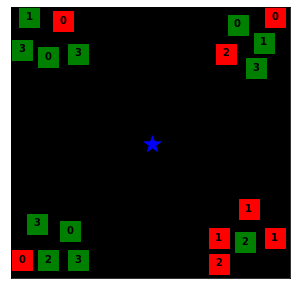

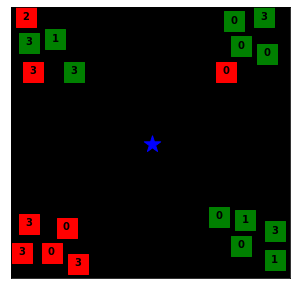

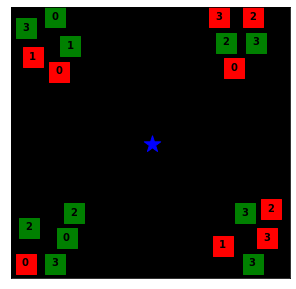

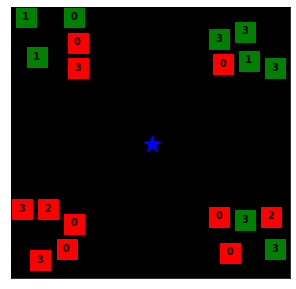

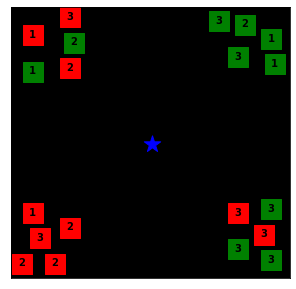

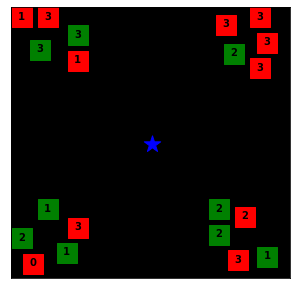

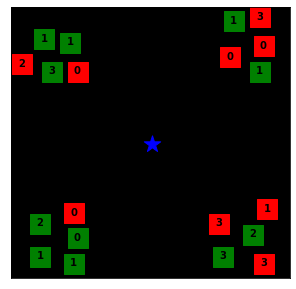

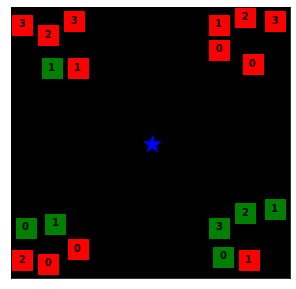

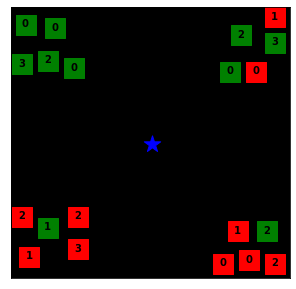

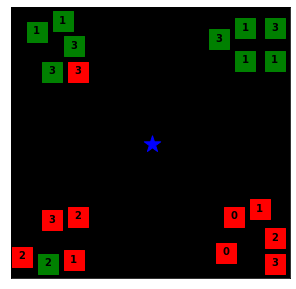

In [110]:
for l in original_gameplay_levels:
    plot_control(l["frame_data"]['objects'])
#     plot_control(l["frame_data"])

In [75]:
def cluster_centroids(cluster_number):

    if cluster_number == 1:
        return CENTROID_LOW, CENTROID_LOW
    elif cluster_number == 2:
        return CENTROID_HIGH, CENTROID_LOW
    elif cluster_number == 3:
        return CENTROID_HIGH, CENTROID_HIGH
    else:
        return CENTROID_LOW, CENTROID_HIGH

    
def reconfigure_objects_to_crosses(level_config):
    
    new_objects = []
    old_copy = copy.deepcopy(config['frame_data']["objects"])
    for cluster in [1, 2, 3, 4]:
        
        cluster_objects = [c for c in old_copy if c['cluster_id'] == cluster]
        x, y = cluster_centroids(cluster)
        
        d = 8
        update_sequence = [(0, 0), (0, d), (d, 0), (0, -d), (-d, 0)]
        
        for i, (o, update) in enumerate(zip(cluster_objects, update_sequence)):            
            o['x'] = x + update[0]
            o['y'] = y + update[1]
            new_objects.append(o)
            
    return new_objects

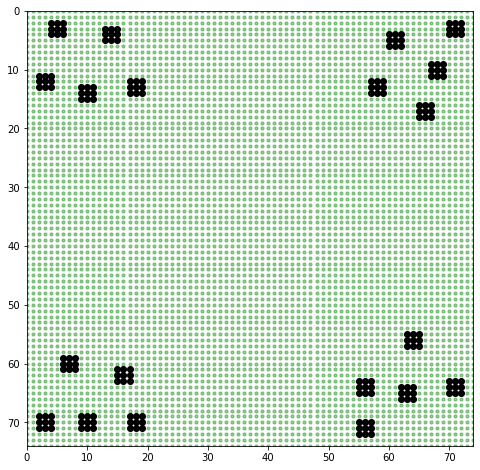

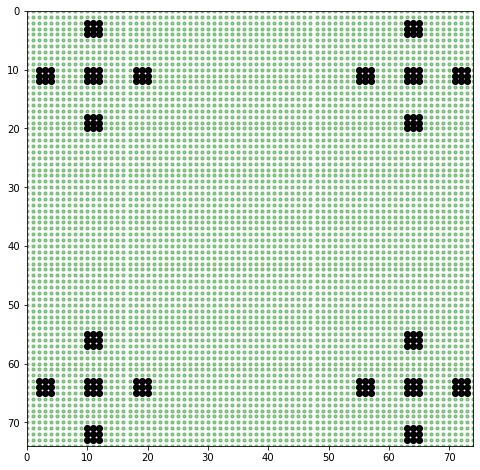

In [76]:
# Check a level
for level, config in enumerate(original_gameplay_levels[:1]):
    
    objects = config['frame_data']["objects"]
    plt.figure(figsize=(8,8))
    plot_objects(objects, range(0, 75))
    
    new_objects = reconfigure_objects_to_crosses(config)
    plt.figure(figsize=(8,8))
    plot_objects(new_objects, range(0, 75))

In [77]:
to_reconfigure = copy.deepcopy(original_gameplay_levels)

for config in to_reconfigure:    
    new_objects = reconfigure_objects_to_crosses(config)
    config['frame_data']["objects"] = new_objects

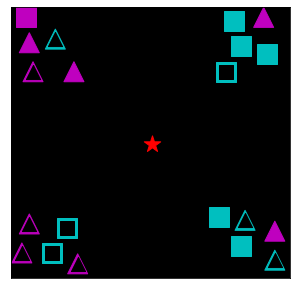

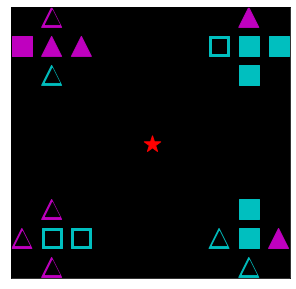

In [116]:
plot_boolean_colors(original_gameplay_levels[1]["frame_data"]['objects'], class_features=feature)

plot_boolean_colors(to_reconfigure[1]["frame_data"]['objects'], class_features=feature)

In [78]:
json.dumps(to_reconfigure)

'[{"frame_data": {"ms_elapsed": 0, "objects": [{"cluster_id": 1, "mask_value": 1, "value": 1, "x": 11, "y": 11}, {"cluster_id": 1, "mask_value": 0, "value": 1, "x": 11, "y": 19}, {"cluster_id": 1, "mask_value": 3, "value": 1, "x": 19, "y": 11}, {"cluster_id": 1, "mask_value": 3, "value": 1, "x": 11, "y": 3}, {"cluster_id": 1, "mask_value": 0, "value": -1, "x": 3, "y": 11}, {"cluster_id": 2, "mask_value": 1, "value": 1, "x": 64, "y": 11}, {"cluster_id": 2, "mask_value": 0, "value": 1, "x": 64, "y": 19}, {"cluster_id": 2, "mask_value": 3, "value": 1, "x": 72, "y": 11}, {"cluster_id": 2, "mask_value": 2, "value": -1, "x": 64, "y": 3}, {"cluster_id": 2, "mask_value": 0, "value": -1, "x": 56, "y": 11}, {"cluster_id": 3, "mask_value": 2, "value": 1, "x": 64, "y": 64}, {"cluster_id": 3, "mask_value": 1, "value": -1, "x": 64, "y": 72}, {"cluster_id": 3, "mask_value": 2, "value": -1, "x": 72, "y": 64}, {"cluster_id": 3, "mask_value": 1, "value": -1, "x": 64, "y": 56}, {"cluster_id": 3, "mask_va

In [79]:
pp.pprint(to_reconfigure[0])

{ 'frame_data': { 'ms_elapsed': 0,
                  'objects': [ {'cluster_id': 1, 'mask_value': 1, 'value': 1, 'x': 11, 'y': 11},
                               {'cluster_id': 1, 'mask_value': 0, 'value': 1, 'x': 11, 'y': 19},
                               {'cluster_id': 1, 'mask_value': 3, 'value': 1, 'x': 19, 'y': 11},
                               {'cluster_id': 1, 'mask_value': 3, 'value': 1, 'x': 11, 'y': 3},
                               {'cluster_id': 1, 'mask_value': 0, 'value': -1, 'x': 3, 'y': 11},
                               {'cluster_id': 2, 'mask_value': 1, 'value': 1, 'x': 64, 'y': 11},
                               {'cluster_id': 2, 'mask_value': 0, 'value': 1, 'x': 64, 'y': 19},
                               {'cluster_id': 2, 'mask_value': 3, 'value': 1, 'x': 72, 'y': 11},
                               {'cluster_id': 2, 'mask_value': 2, 'value': -1, 'x': 64, 'y': 3},
                               {'cluster_id': 2, 'mask_value': 0, 'value': -1, 'x': 56, 'y': 

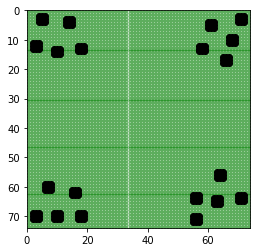

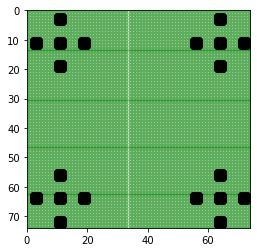

In [87]:
for i in range(0, 1):

    plt.figure(figsize=(4, 4))    
    plot_objects(data[i]['frame_data']["objects"], range(0, 75))

    plt.figure(figsize=(4, 4))    
    plot_objects(to_reconfigure[i]['frame_data']["objects"], range(0, 75))

In [82]:
original_practice_rounds = [{"game_metadata": {"name": "boolean1.0_practice", "level_duration_seconds": 8, "max_abs_value": 10, "min_abs_value": 1, "grid_size": 75, "player_size": 5, "object_size": 3, "object_padding": 7, "cluster_width": 20, "ratio_negative_to_zero": 0.7, "uuid": "1420a1e9-ef11-468b-aefd-ae50165dbd7c", "level_number": 1, "max_cluster_value": 4, "cluster_configs": [{"centroid": [11, 11], "pos_objects": 4, "num_objects": 4, "id": 1, "actual_positive_value": 4, "actual_negative_value": 0}, {"centroid": [64, 11], "pos_objects": 3, "num_objects": 3, "id": 2, "actual_positive_value": 3, "actual_negative_value": 0}]}, "frame_data": {"objects": [{"x": 5, "y": 15, "value": 1, "mask_value": 3, "cluster_id": 1, "objectTint": "0x555555", "objectShape": "blankSquare"}, {"x": 15, "y": 15, "value": 1, "mask_value": 1, "cluster_id": 1, "objectTint": "0x555555", "objectShape": "blankSquare"}, {"x": 16, "y": 5, "value": 1, "mask_value": 0, "cluster_id": 1, "objectTint": "0x555555", "objectShape": "blankSquare"}, {"x": 9, "y": 3, "value": 1, "mask_value": 3, "cluster_id": 1, "objectTint": "0x555555", "objectShape": "blankSquare"}, {"x": 67, "y": 11, "value": 1, "mask_value": 2, "cluster_id": 2, "objectTint": "0x555555", "objectShape": "blankSquare"}, {"x": 58, "y": 11, "value": 1, "mask_value": 1, "cluster_id": 2, "objectTint": "0x555555", "objectShape": "blankSquare"}, {"x": 63, "y": 18, "value": 1, "mask_value": 2, "cluster_id": 2, "objectTint": "0x555555", "objectShape": "blankSquare"}], "player": {"x": 38, "y": 38}, "score": 0, "ms_elapsed": 0}}, {"game_metadata": {"name": "boolean1.0_practice", "level_duration_seconds": 8, "max_abs_value": 10, "min_abs_value": 1, "grid_size": 75, "player_size": 5, "object_size": 3, "object_padding": 7, "cluster_width": 20, "ratio_negative_to_zero": 0.7, "uuid": "9f263746-853a-4ddd-b82e-9556c675e181", "level_number": 2, "max_cluster_value": 2, "cluster_configs": [{"centroid": [11, 11], "pos_objects": 2, "num_objects": 5, "id": 1, "actual_positive_value": 2, "actual_negative_value": -3}, {"centroid": [11, 64], "pos_objects": 2, "num_objects": 5, "id": 2, "actual_positive_value": 2, "actual_negative_value": -3}]}, "frame_data": {"objects": [{"x": 8, "y": 9, "value": 1, "mask_value": 0, "cluster_id": 1, "objectTint": "0x555555", "objectShape": "blankSquare"}, {"x": 14, "y": 8, "value": 1, "mask_value": 3, "cluster_id": 1, "objectTint": "0x555555", "objectShape": "blankSquare"}, {"x": 7, "y": 15, "value": -1, "mask_value": 0, "cluster_id": 1, "objectTint": "0x555555", "objectShape": "blankSquare"}, {"x": 18, "y": 17, "value": -1, "mask_value": 3, "cluster_id": 1, "objectTint": "0x555555", "objectShape": "blankSquare"}, {"x": 7, "y": 3, "value": -1, "mask_value": 0, "cluster_id": 1, "objectTint": "0x555555", "objectShape": "blankSquare"}, {"x": 17, "y": 63, "value": 1, "mask_value": 3, "cluster_id": 2, "objectTint": "0x555555", "objectShape": "blankSquare"}, {"x": 11, "y": 56, "value": 1, "mask_value": 3, "cluster_id": 2, "objectTint": "0x555555", "objectShape": "blankSquare"}, {"x": 4, "y": 59, "value": -1, "mask_value": 3, "cluster_id": 2, "objectTint": "0x555555", "objectShape": "blankSquare"}, {"x": 14, "y": 71, "value": -1, "mask_value": 1, "cluster_id": 2, "objectTint": "0x555555", "objectShape": "blankSquare"}, {"x": 8, "y": 66, "value": -1, "mask_value": 1, "cluster_id": 2, "objectTint": "0x555555", "objectShape": "blankSquare"}], "player": {"x": 38, "y": 38}, "score": 0, "ms_elapsed": 0}}, {"game_metadata": {"name": "boolean1.0_practice", "level_duration_seconds": 8, "max_abs_value": 10, "min_abs_value": 1, "grid_size": 75, "player_size": 5, "object_size": 3, "object_padding": 7, "cluster_width": 20, "ratio_negative_to_zero": 0.7, "uuid": "f6308e6f-e87b-497f-9dc8-7ae48e4b86c5", "level_number": 3, "max_cluster_value": 3, "cluster_configs": [{"centroid": [11, 11], "pos_objects": 3, "num_objects": 5, "id": 1, "actual_positive_value": 3, "actual_negative_value": -2}, {"centroid": [64, 64], "pos_objects": 2, "num_objects": 5, "id": 2, "actual_positive_value": 2, "actual_negative_value": -3}]}, "frame_data": {"objects": [{"x": 7, "y": 18, "value": 1, "mask_value": 2, "cluster_id": 1, "objectTint": "0x0000FF", "objectShape": "blankCircle"}, {"x": 17, "y": 17, "value": 1, "mask_value": 0, "cluster_id": 1, "objectTint": "0x0000FF", "objectShape": "blankCircle"}, {"x": 18, "y": 10, "value": 1, "mask_value": 1, "cluster_id": 1, "objectTint": "0x0000FF", "objectShape": "blankCircle"}, {"x": 12, "y": 8, "value": -1, "mask_value": 3, "cluster_id": 1, "objectTint": "0xFF0000", "objectShape": "blankSquare"}, {"x": 4, "y": 7, "value": -1, "mask_value": 0, "cluster_id": 1, "objectTint": "0xFF0000", "objectShape": "blankSquare"}, {"x": 64, "y": 60, "value": 1, "mask_value": 3, "cluster_id": 2, "objectTint": "0x0000FF", "objectShape": "blankCircle"}, {"x": 56, "y": 64, "value": 1, "mask_value": 0, "cluster_id": 2, "objectTint": "0x0000FF", "objectShape": "blankCircle"}, {"x": 69, "y": 66, "value": -1, "mask_value": 0, "cluster_id": 2, "objectTint": "0xFF0000", "objectShape": "blankSquare"}, {"x": 57, "y": 56, "value": -1, "mask_value": 0, "cluster_id": 2, "objectTint": "0xFF0000", "objectShape": "blankSquare"}, {"x": 58, "y": 70, "value": -1, "mask_value": 2, "cluster_id": 2, "objectTint": "0xFF0000", "objectShape": "blankSquare"}], "player": {"x": 38, "y": 38}, "score": 0, "ms_elapsed": 0}}, {"game_metadata": {"name": "boolean1.0_practice", "level_duration_seconds": 8, "max_abs_value": 10, "min_abs_value": 1, "grid_size": 75, "player_size": 5, "object_size": 3, "object_padding": 7, "cluster_width": 20, "ratio_negative_to_zero": 0.7, "uuid": "9a587936-f06b-4fbd-a0b2-1c853736f15a", "level_number": 4, "max_cluster_value": 5, "cluster_configs": [{"centroid": [11, 11], "pos_objects": 3, "num_objects": 5, "id": 1, "actual_positive_value": 3, "actual_negative_value": -2}, {"centroid": [64, 11], "pos_objects": 3, "num_objects": 5, "id": 2, "actual_positive_value": 3, "actual_negative_value": -2}, {"centroid": [64, 64], "pos_objects": 5, "num_objects": 5, "id": 3, "actual_positive_value": 5, "actual_negative_value": 0}, {"centroid": [11, 64], "pos_objects": 2, "num_objects": 5, "id": 4, "actual_positive_value": 2, "actual_negative_value": -3}]}, "frame_data": {"objects": [{"x": 15, "y": 18, "value": 1, "mask_value": 2, "cluster_id": 1, "objectTint": "0x0000FF", "objectShape": "blankCircle"}, {"x": 8, "y": 14, "value": 1, "mask_value": 3, "cluster_id": 1, "objectTint": "0x0000FF", "objectShape": "blankCircle"}, {"x": 13, "y": 4, "value": 1, "mask_value": 3, "cluster_id": 1, "objectTint": "0x0000FF", "objectShape": "blankCircle"}, {"x": 3, "y": 4, "value": -1, "mask_value": 2, "cluster_id": 1, "objectTint": "0xFF0000", "objectShape": "blankSquare"}, {"x": 17, "y": 10, "value": -1, "mask_value": 1, "cluster_id": 1, "objectTint": "0xFF0000", "objectShape": "blankSquare"}, {"x": 68, "y": 12, "value": 1, "mask_value": 1, "cluster_id": 2, "objectTint": "0x0000FF", "objectShape": "blankCircle"}, {"x": 59, "y": 6, "value": 1, "mask_value": 1, "cluster_id": 2, "objectTint": "0x0000FF", "objectShape": "blankCircle"}, {"x": 58, "y": 17, "value": 1, "mask_value": 0, "cluster_id": 2, "objectTint": "0x0000FF", "objectShape": "blankCircle"}, {"x": 68, "y": 18, "value": -1, "mask_value": 2, "cluster_id": 2, "objectTint": "0xFF0000", "objectShape": "blankSquare"}, {"x": 68, "y": 6, "value": -1, "mask_value": 3, "cluster_id": 2, "objectTint": "0xFF0000", "objectShape": "blankSquare"}, {"x": 61, "y": 56, "value": 1, "mask_value": 3, "cluster_id": 3, "objectTint": "0x0000FF", "objectShape": "blankCircle"}, {"x": 64, "y": 63, "value": 1, "mask_value": 0, "cluster_id": 3, "objectTint": "0x0000FF", "objectShape": "blankCircle"}, {"x": 61, "y": 71, "value": 1, "mask_value": 3, "cluster_id": 3, "objectTint": "0x0000FF", "objectShape": "blankCircle"}, {"x": 69, "y": 69, "value": 1, "mask_value": 1, "cluster_id": 3, "objectTint": "0x0000FF", "objectShape": "blankCircle"}, {"x": 58, "y": 64, "value": 1, "mask_value": 0, "cluster_id": 3, "objectTint": "0x0000FF", "objectShape": "blankCircle"}, {"x": 11, "y": 68, "value": 1, "mask_value": 0, "cluster_id": 4, "objectTint": "0x0000FF", "objectShape": "blankCircle"}, {"x": 4, "y": 63, "value": 1, "mask_value": 3, "cluster_id": 4, "objectTint": "0x0000FF", "objectShape": "blankCircle"}, {"x": 4, "y": 57, "value": -1, "mask_value": 3, "cluster_id": 4, "objectTint": "0xFF0000", "objectShape": "blankSquare"}, {"x": 14, "y": 61, "value": -1, "mask_value": 1, "cluster_id": 4, "objectTint": "0xFF0000", "objectShape": "blankSquare"}, {"x": 17, "y": 70, "value": -1, "mask_value": 3, "cluster_id": 4, "objectTint": "0xFF0000", "objectShape": "blankSquare"}], "player": {"x": 38, "y": 38}, "score": 0, "ms_elapsed": 0}}]

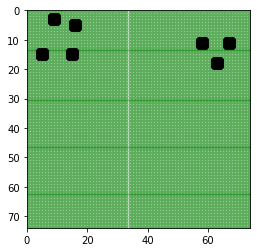

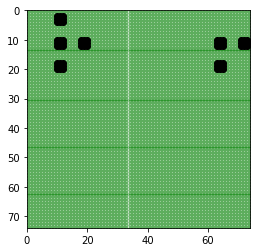

In [88]:
practice_to_reconfigure = copy.deepcopy(original_practice_rounds)

for config in practice_to_reconfigure:    
    new_objects = reconfigure_objects_to_crosses(config)
    config['frame_data']["objects"] = new_objects

plt.figure(figsize=(4, 4))
plot_objects(original_practice_rounds[0]['frame_data']["objects"], range(0, 75))
plt.figure(figsize=(4, 4))
plot_objects(practice_to_reconfigure[0]['frame_data']["objects"], range(0, 75))

In [89]:
json.dumps(practice_to_reconfigure)

'[{"game_metadata": {"name": "boolean1.0_practice", "level_duration_seconds": 8, "max_abs_value": 10, "min_abs_value": 1, "grid_size": 75, "player_size": 5, "object_size": 3, "object_padding": 7, "cluster_width": 20, "ratio_negative_to_zero": 0.7, "uuid": "1420a1e9-ef11-468b-aefd-ae50165dbd7c", "level_number": 1, "max_cluster_value": 4, "cluster_configs": [{"centroid": [11, 11], "pos_objects": 4, "num_objects": 4, "id": 1, "actual_positive_value": 4, "actual_negative_value": 0}, {"centroid": [64, 11], "pos_objects": 3, "num_objects": 3, "id": 2, "actual_positive_value": 3, "actual_negative_value": 0}]}, "frame_data": {"objects": [{"x": 11, "y": 11, "value": 1, "mask_value": 3, "cluster_id": 1, "objectTint": "0x555555", "objectShape": "blankSquare"}, {"x": 11, "y": 19, "value": 1, "mask_value": 1, "cluster_id": 1, "objectTint": "0x555555", "objectShape": "blankSquare"}, {"x": 19, "y": 11, "value": 1, "mask_value": 0, "cluster_id": 1, "objectTint": "0x555555", "objectShape": "blankSquare

In [90]:
pp.pprint(practice_to_reconfigure[0])

{ 'frame_data': { 'ms_elapsed': 0,
                  'objects': [ { 'cluster_id': 1,
                                 'mask_value': 3,
                                 'objectShape': 'blankSquare',
                                 'objectTint': '0x555555',
                                 'value': 1,
                                 'x': 11,
                                 'y': 11},
                               { 'cluster_id': 1,
                                 'mask_value': 1,
                                 'objectShape': 'blankSquare',
                                 'objectTint': '0x555555',
                                 'value': 1,
                                 'x': 11,
                                 'y': 19},
                               { 'cluster_id': 1,
                                 'mask_value': 0,
                                 'objectShape': 'blankSquare',
                                 'objectTint': '0x555555',
                                 'value